# Pivoted full data

En este documento se crean las tablas para las predicciones.

In [1]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_recall_fscore_support,
    accuracy_score
)

from catboost import CatBoostClassifier, Pool

import matplotlib.pyplot as plt
import seaborn as sns

from scripts import style
style.mpl_apply()

In [2]:

PATH = "data/cephalosporines_clean/"
df = pd.read_parquet(PATH + "pivoted_full_data_imputed.parquet")
df.head()

AGE_Y  WEIGHT_KG  HEIGHT_CM  GENDER_CODE  furosemide  \
REPORT_ID                                                         
164         68.0  47.000000     173.00            0           1   
173         42.0  82.000000     180.00            0           0   
180         29.0  77.652228     165.00            1           0   
346         59.0  62.400000     159.70            1           0   
356         21.0  60.000000     164.52            1           0   

           chlorpromazine  cephalothin  chlordiazepoxide hydrochloride  \
REPORT_ID                                                                
164                     1            2                               2   
173                     0            2                               0   
180                     0            0                               0   
346                     0            2                               0   
356                     0            0                               0   

           fursemide  hydralazine hydrochloride  ...  \
REPORT_ID                                        ...   
164                1                          1  ...   
173                0                          0  ...   
180                0                          0  ...   
346                0                          0  ...   
356                0                          0  ...   

           Pregnancy, puerperium and perinatal conditions  Product issues  \
REPORT_ID                                                                   
164                                                     0               0   
173                                                     0               0   
180                                                     0               0   
346                                                     0               0   
356                                                     0               0   

           Psychiatric disorders  Renal and urinary disorders  \
REPORT_ID                                                       
164                            0                            0   
173                            0                            0   
180                            0                            0   
346                            0                            0   
356                            0                            0   

           Reproductive system and breast disorders  \
REPORT_ID                                             
164                                               0   
173                                               0   
180                                               0   
346                                               0   
356                                               0   

           Respiratory, thoracic and mediastinal disorders  \
REPORT_ID                                                    
164                                                      0   
173                                                      0   
180                                                      0   
346                                                      0   
356                                                      0   

           Skin and subcutaneous tissue disorders  Social circumstances  \
REPORT_ID                                                                 
164                                             0                     0   
173                                             0                     0   
180                                             0                     0   
346                                             1                     0   
356                                             0                     0   

           Surgical and medical procedures  Vascular disorders  
REPORT_ID                                                       
164                                      0                   0  
173                                      0                   0  
180                       

In [3]:
soc_cols = [
    "Blood and lymphatic system disorders",
    "Cardiac disorders",
    "Congenital, familial and genetic disorders",
    "Ear and labyrinth disorders",
    "Endocrine disorders",
    "Eye disorders",
    "Gastrointestinal disorders",
    "General disorders and administration site conditions",
    "Hepatobiliary disorders",
    "Immune system disorders",
    "Infections and infestations",
    "Injury, poisoning and procedural complications",
    "Investigations",
    "Metabolism and nutrition disorders",
    "Musculoskeletal and connective tissue disorders",
    "Neoplasms benign, malignant and unspecified (incl cysts and polyps)",
    "Nervous system disorders",
    "Pregnancy, puerperium and perinatal conditions",
    "Product issues",
    "Psychiatric disorders",
    "Renal and urinary disorders",
    "Reproductive system and breast disorders",
    "Respiratory, thoracic and mediastinal disorders",
    "Skin and subcutaneous tissue disorders",
    "Social circumstances",
    "Surgical and medical procedures",
    "Vascular disorders",
]


In [4]:
# Assuming df is already a pandas DataFrame
df_bin = df.copy()

# Binarize the SOC columns: set to 1 if > 0, else 0
for c in soc_cols:
    df_bin[c] = (df_bin[c] > 0).astype('int8')

all_cols = df_bin.columns

feature_cols = [
    c for c in all_cols
    if c not in soc_cols and c != "REPORT_ID"
]

# df_bin is already in pandas format
X = df_bin[feature_cols]
Y = df_bin[soc_cols]

# Free memory
df = None
df_bin = None

# uint32 vs int8 memory usage
# uint32 uses 4 bytes per value, int8 uses 1 byte per value
# so converting float to uint32 is better than leaving as float. int8 goes from -128 to 127, uint32 goes from 0 to 4,294,967,295 (for example, if the number is 300, in int8 it would overflow, but in uint32 it would be fine and they both use less memory than float)
print(X.info(memory_usage='deep'))

# make all of them, except AGE_Y, WEIGHT_KG, HEIGHT_CM int8
int8_cols = [c for c in X.columns if c not in ['AGE_Y', 'WEIGHT_KG', 'HEIGHT_CM']]
X[int8_cols] = X[int8_cols].astype('int8')
print(X.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Index: 17854 entries, 164 to 908149644
Columns: 9093 entries, AGE_Y to 
dtypes: float64(3), int32(2), uint32(9088)
memory usage: 619.6 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 17854 entries, 164 to 908149644
Columns: 9093 entries, AGE_Y to 
dtypes: float64(3), int8(9090)
memory usage: 155.3 MB
None


In [5]:
Y.head()

Blood and lymphatic system disorders  Cardiac disorders  \
REPORT_ID                                                            
164                                           0                  0   
173                                           0                  0   
180                                           0                  0   
346                                           0                  0   
356                                           0                  0   

           Congenital, familial and genetic disorders  \
REPORT_ID                                               
164                                                 0   
173                                                 0   
180                                                 0   
346                                                 0   
356                                                 0   

           Ear and labyrinth disorders  Endocrine disorders  Eye disorders  \
REPORT_ID                                                                    
164                                  0                    0              1   
173                                  0                    0              0   
180                                  0                    0              0   
346                                  0                    0              0   
356                                  0                    0              0   

           Gastrointestinal disorders  \
REPORT_ID                               
164                                 0   
173                                 0   
180                                 1   
346                                 0   
356                                 1   

           General disorders and administration site conditions  \
REPORT_ID                                                         
164                                                        0      
173                                                        0      
180                                                        0      
346                                                        0      
356                                                        0      

           Hepatobiliary disorders  Immune system disorders  ...  \
REPORT_ID                                                    ...   
164                              0                        0  ...   
173                              0                        0  ...   
180                              0                        0  ...   
346                              0                        0  ...   
356                              0                        0  ...   

           Pregnancy, puerperium and perinatal conditions  Product issues  \
REPORT_ID                                                                   
164                                                     0               0   
173                                                     0               0   
180                                                     0               0   
346                                                     0               0   
356                                                     0               0   

           Psychiatric disorders  Renal and urinary disorders  \
REPORT_ID                                                       
164                            0                            0   
173                            0                            0   
180                            0                            0   
346                            0                            0   
356                            0                            0   

           Reproductive system and breast disorders  \
REPORT_ID                                             
164                                               0   
173                                               0   
180                                               0   
346                                               0   
356         

In [9]:
X.head()

AGE_Y  WEIGHT_KG  HEIGHT_CM  GENDER_CODE  furosemide  \
REPORT_ID                                                         
164         68.0  47.000000     173.00            0           1   
173         42.0  82.000000     180.00            0           0   
180         29.0  77.652228     165.00            1           0   
346         59.0  62.400000     159.70            1           0   
356         21.0  60.000000     164.52            1           0   

           chlorpromazine  cephalothin  chlordiazepoxide hydrochloride  \
REPORT_ID                                                                
164                     1            2                               2   
173                     0            2                               0   
180                     0            0                               0   
346                     0            2                               0   
356                     0            0                               0   

           fursemide  hydralazine hydrochloride  ...  prunus cerasus extract  \
REPORT_ID                                        ...                           
164                1                          1  ...                       0   
173                0                          0  ...                       0   
180                0                          0  ...                       0   
346                0                          0  ...                       0   
356                0                          0  ...                       0   

           prunus cerasus root  prunus cerasus bark  cilgavimab  tixagevimab  \
REPORT_ID                                                                      
164                          0                    0           0            0   
173                          0                    0           0            0   
180                          0                    0           0            0   
346                          0                    0           0            0   
356                          0                    0           0            0   

           daratumumab (humax-cd38)  sigvotatug vedotin  cephalosporin nos  \
REPORT_ID                                                                    
164                               0                   0                  0   
173                               0                   0                  0   
180                               0                   0                  0   
346                               0                   0                  0   
356                               0                   0                  0   

           ravulizumab     
REPORT_ID                  
164                  0  0  
173                  0  0  
180                  0  0  
346                  0  0  
356                  0  0  

[5 rows x 9093 columns]

# Model

In [10]:
feature_names = X.columns.tolist()
soc_names = Y.columns.tolist()
K = len(soc_names)

print(f"Number of features: {len(feature_names)}, Number of SOCs: {K}")

Number of features: 9093, Number of SOCs: 27


In [11]:
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X,
    Y,
    test_size=0.1,
    random_state=386
)


In [14]:
def train_catboost_binary(
    X_train, y_train,
    X_valid, y_valid,
    feature_names,
    random_seed=386
):
    train_pool = Pool(
        data=X_train,
        label=y_train,
        feature_names=feature_names
    )
    valid_pool = Pool(
        data=X_valid,
        label=y_valid,
        feature_names=feature_names
    )

    model = CatBoostClassifier(
        # Objective / metrics
        loss_function="Logloss",
        eval_metric="AUC",               # optimize AUC on valid
        custom_metric=["AUC", "PRAUC", "Logloss"],
        metric_period=50,                # printed every 50 iters (AUC is on CPU)

        # Imbalance handling
        auto_class_weights="Balanced",   # good default for your rare SOCs

        # Main capacity / speed knobs
        depth=9,                        # deeper than 6, more expressive
        learning_rate=0.05,             # small LR for many iterations
        iterations=10000,               # large, will be cut by early stopping
        l2_leaf_reg=6.0,                # a bit stronger regularization

        # Stochastic regularization
        bootstrap_type="Poisson",       # GPU-friendly stochastic bootstrap
        subsample=0.8,                  # row sampling
        # rsm=0.8,                        # column sampling (Random Subspace Method)

        # Leaf estimation
        leaf_estimation_iterations=4,   # more precise leaf values
        leaf_estimation_method="Newton",# default, good for Logloss

        # GPU
        task_type="GPU",
        devices="0",

        # Overfitting control
        od_type="Iter",
        od_wait=400,                    # wait 400 iters without AUC improvement
        use_best_model=True,

        # Repro / logging
        random_seed=random_seed,
        verbose=100
    )

    model.fit(
        train_pool,
        eval_set=valid_pool
    )

    return model


In [15]:
models = {}
metrics = []

for k, soc in enumerate(soc_names):
    print(f"\n=== Training model for SOC: {soc} ({k+1}/{K}) ===")

    y_train_k = Y_train[soc]
    y_valid_k = Y_valid[soc]

    model_k = train_catboost_binary(
        X_train, y_train_k,
        X_valid, y_valid_k,
        feature_names
    )

    models[soc] = model_k

    # Predict probabilities on validation
    p_valid_k = model_k.predict_proba(X_valid)[:, 1]

    # Metrics
    # AUC and AP might fail if only 0s/1s present; guard it
    if y_valid_k.nunique() == 2:
        auc_k = roc_auc_score(y_valid_k, p_valid_k)
        ap_k = average_precision_score(y_valid_k, p_valid_k)
    else:
        auc_k = np.nan
        ap_k = np.nan

    # F1 at default 0.5 threshold
    yhat_valid_k = (p_valid_k >= 0.5).astype(int)
    f1_k = f1_score(y_valid_k, yhat_valid_k, zero_division=0)

    prevalence = y_valid_k.mean()

    metrics.append({
        "SOC": soc,
        "prevalence_valid": prevalence,
        "AUC": auc_k,
        "AP": ap_k,
        "F1_thr_0.5": f1_k
    })


=== Training model for SOC: Blood and lymphatic system disorders (1/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6848543	best: 0.6848543 (0)	total: 172ms	remaining: 28m 39s
100:	test: 0.8021400	best: 0.8022057 (99)	total: 59.8s	remaining: 1h 37m 40s
200:	test: 0.8163538	best: 0.8165238 (196)	total: 1m 57s	remaining: 1h 35m 27s
300:	test: 0.8239825	best: 0.8240405 (298)	total: 2m 19s	remaining: 1h 14m 41s
400:	test: 0.8287140	best: 0.8287140 (400)	total: 2m 32s	remaining: 1h 59s
500:	test: 0.8307376	best: 0.8311357 (453)	total: 3m 8s	remaining: 59m 30s
600:	test: 0.8306197	best: 0.8316982 (558)	total: 3m 42s	remaining: 58m 6s
700:	test: 0.8336039	best: 0.8336387 (699)	total: 4m 6s	remaining: 54m 33s
800:	test: 0.8343886	best: 0.8345239 (785)	total: 4m 23s	remaining: 50m 25s
900:	test: 0.8341915	best: 0.8345317 (829)	total: 4m 44s	remaining: 47m 57s
1000:	test: 0.8335807	best: 0.8347365 (910)	total: 5m 2s	remaining: 45m 18s
1100:	test: 0.8328308	best: 0.8347365 (910)	total: 5m 28s	remaining: 44m 15s
1200:	test: 0.8345124	best: 0.8347365 (910)	total: 5m 48s	remaining: 42m 31s
1300:	test: 

Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6550333	best: 0.6550333 (0)	total: 127ms	remaining: 21m 12s
100:	test: 0.7974293	best: 0.7992292 (96)	total: 12.6s	remaining: 20m 32s
200:	test: 0.8138714	best: 0.8163441 (181)	total: 25.2s	remaining: 20m 27s
300:	test: 0.8152391	best: 0.8176845 (262)	total: 37.7s	remaining: 20m 13s
400:	test: 0.8235435	best: 0.8236092 (396)	total: 50.2s	remaining: 20m 2s
500:	test: 0.8296270	best: 0.8298677 (499)	total: 1m 2s	remaining: 19m 47s
600:	test: 0.8277997	best: 0.8298677 (499)	total: 1m 15s	remaining: 19m 35s
700:	test: 0.8271706	best: 0.8298677 (499)	total: 1m 27s	remaining: 19m 23s
800:	test: 0.8266618	best: 0.8298677 (499)	total: 1m 43s	remaining: 19m 46s
900:	test: 0.8307703	best: 0.8317113 (871)	total: 2m 8s	remaining: 21m 37s
1000:	test: 0.8300646	best: 0.8317113 (871)	total: 2m 22s	remaining: 21m 20s
1100:	test: 0.8296707	best: 0.8317113 (871)	total: 2m 34s	remaining: 20m 49s
1200:	test: 0.8315089	best: 0.8317879 (1160)	total: 2m 46s	remaining: 20m 17s
1300:	test: 0.8313010

Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7911347	best: 0.7911347 (0)	total: 125ms	remaining: 20m 49s
100:	test: 0.9053240	best: 0.9091384 (49)	total: 49.1s	remaining: 1h 20m 15s
200:	test: 0.8818759	best: 0.9091384 (49)	total: 1m 50s	remaining: 1h 29m 48s
300:	test: 0.8759335	best: 0.9091384 (49)	total: 3m 22s	remaining: 1h 48m 53s
400:	test: 0.8807516	best: 0.9091384 (49)	total: 3m 37s	remaining: 1h 26m 57s
bestTest = 0.9091383517
bestIteration = 49
Shrink model to first 50 iterations.

=== Training model for SOC: Ear and labyrinth disorders (4/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6234842	best: 0.6234842 (0)	total: 116ms	remaining: 19m 19s
100:	test: 0.7970390	best: 0.7994293 (93)	total: 11.7s	remaining: 19m 11s
200:	test: 0.7996214	best: 0.8014353 (123)	total: 23.4s	remaining: 19m 1s
300:	test: 0.7961745	best: 0.8014353 (123)	total: 35.2s	remaining: 18m 52s
400:	test: 0.7969091	best: 0.8014353 (123)	total: 46.9s	remaining: 18m 43s
500:	test: 0.7990337	best: 0.8015653 (435)	total: 58.6s	remaining: 18m 31s
600:	test: 0.7975080	best: 0.8015653 (435)	total: 1m 10s	remaining: 18m 19s
700:	test: 0.7965587	best: 0.8015653 (435)	total: 1m 22s	remaining: 18m 8s
800:	test: 0.7956207	best: 0.8015653 (435)	total: 1m 34s	remaining: 18m
bestTest = 0.8015652597
bestIteration = 435
Shrink model to first 436 iterations.

=== Training model for SOC: Endocrine disorders (5/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7967734	best: 0.7967734 (0)	total: 113ms	remaining: 18m 54s
100:	test: 0.9221511	best: 0.9583611 (45)	total: 11.8s	remaining: 19m 19s
200:	test: 0.8788732	best: 0.9583611 (45)	total: 24.4s	remaining: 19m 48s
300:	test: 0.8818950	best: 0.9583611 (45)	total: 36.5s	remaining: 19m 36s
400:	test: 0.8853265	best: 0.9583611 (45)	total: 48.9s	remaining: 19m 30s
bestTest = 0.9583610892
bestIteration = 45
Shrink model to first 46 iterations.

=== Training model for SOC: Eye disorders (6/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6369414	best: 0.6369414 (0)	total: 126ms	remaining: 21m 2s
100:	test: 0.7641964	best: 0.7649795 (86)	total: 12.1s	remaining: 19m 50s
200:	test: 0.7800662	best: 0.7806195 (182)	total: 24.2s	remaining: 19m 37s
300:	test: 0.7891136	best: 0.7896824 (278)	total: 36.3s	remaining: 19m 30s
400:	test: 0.7953789	best: 0.7958309 (393)	total: 48.4s	remaining: 19m 17s
500:	test: 0.7980596	best: 0.7983012 (491)	total: 1m	remaining: 19m 5s
600:	test: 0.8018157	best: 0.8022131 (599)	total: 1m 12s	remaining: 18m 50s
700:	test: 0.8017144	best: 0.8022131 (599)	total: 1m 24s	remaining: 18m 39s
800:	test: 0.8016131	best: 0.8022131 (599)	total: 1m 36s	remaining: 18m 24s
900:	test: 0.7983791	best: 0.8022131 (599)	total: 1m 47s	remaining: 18m 5s
bestTest = 0.8022131026
bestIteration = 599
Shrink model to first 600 iterations.

=== Training model for SOC: Gastrointestinal disorders (7/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5893735	best: 0.5893735 (0)	total: 130ms	remaining: 21m 42s
100:	test: 0.7125009	best: 0.7125966 (99)	total: 12.2s	remaining: 19m 55s
200:	test: 0.7258374	best: 0.7258374 (200)	total: 23.9s	remaining: 19m 26s
300:	test: 0.7312649	best: 0.7313680 (298)	total: 35.6s	remaining: 19m 7s
400:	test: 0.7320093	best: 0.7322595 (385)	total: 47.6s	remaining: 18m 59s
500:	test: 0.7358994	best: 0.7360760 (499)	total: 59s	remaining: 18m 38s
600:	test: 0.7359288	best: 0.7363613 (587)	total: 1m 10s	remaining: 18m 15s
700:	test: 0.7370228	best: 0.7370228 (700)	total: 1m 21s	remaining: 18m
800:	test: 0.7368295	best: 0.7380441 (752)	total: 1m 32s	remaining: 17m 47s
900:	test: 0.7364919	best: 0.7380441 (752)	total: 1m 44s	remaining: 17m 34s
1000:	test: 0.7374267	best: 0.7380560 (980)	total: 1m 56s	remaining: 17m 25s
1100:	test: 0.7373825	best: 0.7380560 (980)	total: 2m 8s	remaining: 17m 15s
1200:	test: 0.7384314	best: 0.7385657 (1199)	total: 2m 19s	remaining: 17m 1s
1300:	test: 0.7393165	best: 

Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6339336	best: 0.6339336 (0)	total: 143ms	remaining: 23m 52s
100:	test: 0.7006438	best: 0.7006438 (100)	total: 12.1s	remaining: 19m 44s
200:	test: 0.7129419	best: 0.7130317 (197)	total: 23.8s	remaining: 19m 21s
300:	test: 0.7187641	best: 0.7188638 (299)	total: 35.6s	remaining: 19m 8s
400:	test: 0.7225299	best: 0.7225384 (399)	total: 47.3s	remaining: 18m 51s
500:	test: 0.7251690	best: 0.7251690 (500)	total: 58.6s	remaining: 18m 30s
600:	test: 0.7270779	best: 0.7270779 (600)	total: 1m 10s	remaining: 18m 19s
700:	test: 0.7283354	best: 0.7288134 (676)	total: 1m 22s	remaining: 18m 7s
800:	test: 0.7304626	best: 0.7306395 (797)	total: 1m 33s	remaining: 17m 55s
900:	test: 0.7305651	best: 0.7306395 (797)	total: 1m 45s	remaining: 17m 40s
1000:	test: 0.7305188	best: 0.7306395 (797)	total: 1m 56s	remaining: 17m 29s
1100:	test: 0.7303419	best: 0.7308361 (1023)	total: 2m 8s	remaining: 17m 16s
1200:	test: 0.7310881	best: 0.7311246 (1183)	total: 2m 20s	remaining: 17m 5s
1300:	test: 0.7314869

Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6084921	best: 0.6084921 (0)	total: 136ms	remaining: 22m 43s
100:	test: 0.7173175	best: 0.7196191 (92)	total: 12.1s	remaining: 19m 47s
200:	test: 0.7189206	best: 0.7310794 (171)	total: 24.2s	remaining: 19m 41s
300:	test: 0.7376667	best: 0.7376667 (300)	total: 36.6s	remaining: 19m 40s
400:	test: 0.7340159	best: 0.7387460 (326)	total: 48.9s	remaining: 19m 31s
500:	test: 0.7236984	best: 0.7387460 (326)	total: 1m 1s	remaining: 19m 18s
600:	test: 0.7187143	best: 0.7387460 (326)	total: 1m 13s	remaining: 19m 12s
700:	test: 0.7238571	best: 0.7387460 (326)	total: 1m 26s	remaining: 19m 2s
bestTest = 0.7387460172
bestIteration = 326
Shrink model to first 327 iterations.

=== Training model for SOC: Immune system disorders (10/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6704171	best: 0.6704171 (0)	total: 131ms	remaining: 21m 54s
100:	test: 0.7879876	best: 0.7884082 (96)	total: 12.4s	remaining: 20m 12s
200:	test: 0.7943181	best: 0.7949682 (192)	total: 24.5s	remaining: 19m 54s
300:	test: 0.7997814	best: 0.7998161 (297)	total: 36.8s	remaining: 19m 45s
400:	test: 0.8043215	best: 0.8044849 (393)	total: 48.9s	remaining: 19m 30s
500:	test: 0.8047126	best: 0.8060928 (452)	total: 1m 1s	remaining: 19m 18s
600:	test: 0.8062683	best: 0.8062927 (599)	total: 1m 13s	remaining: 19m 5s
700:	test: 0.8062527	best: 0.8066194 (627)	total: 1m 25s	remaining: 18m 53s
800:	test: 0.8058633	best: 0.8067289 (754)	total: 1m 38s	remaining: 18m 49s
900:	test: 0.8050915	best: 0.8067289 (754)	total: 1m 50s	remaining: 18m 40s
1000:	test: 0.8057625	best: 0.8067289 (754)	total: 2m 3s	remaining: 18m 30s
1100:	test: 0.8065169	best: 0.8069236 (1044)	total: 2m 16s	remaining: 18m 20s
1200:	test: 0.8075667	best: 0.8075667 (1200)	total: 2m 29s	remaining: 18m 13s
1300:	test: 0.806722

Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7270403	best: 0.7270403 (0)	total: 122ms	remaining: 20m 23s
100:	test: 0.8441678	best: 0.8441678 (100)	total: 12.6s	remaining: 20m 31s
200:	test: 0.8519177	best: 0.8519177 (200)	total: 25s	remaining: 20m 17s
300:	test: 0.8573928	best: 0.8576305 (298)	total: 37.4s	remaining: 20m 6s
400:	test: 0.8602940	best: 0.8602940 (400)	total: 49.7s	remaining: 19m 50s
500:	test: 0.8618433	best: 0.8620886 (493)	total: 1m 1s	remaining: 19m 29s
600:	test: 0.8632188	best: 0.8633329 (596)	total: 1m 13s	remaining: 19m 12s
700:	test: 0.8639868	best: 0.8641827 (691)	total: 1m 25s	remaining: 18m 59s
800:	test: 0.8652283	best: 0.8652283 (800)	total: 1m 37s	remaining: 18m 45s
900:	test: 0.8653690	best: 0.8654469 (898)	total: 1m 50s	remaining: 18m 33s
1000:	test: 0.8663709	best: 0.8664374 (983)	total: 2m 2s	remaining: 18m 20s
1100:	test: 0.8668823	best: 0.8669032 (1090)	total: 2m 14s	remaining: 18m 6s
1200:	test: 0.8676503	best: 0.8676503 (1200)	total: 2m 26s	remaining: 17m 54s
1300:	test: 0.8684412	

Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6982714	best: 0.6982714 (0)	total: 125ms	remaining: 20m 46s
100:	test: 0.8437817	best: 0.8443742 (88)	total: 12.6s	remaining: 20m 30s
200:	test: 0.8543444	best: 0.8545904 (199)	total: 24.6s	remaining: 19m 57s
300:	test: 0.8583137	best: 0.8583935 (290)	total: 36.6s	remaining: 19m 40s
400:	test: 0.8608278	best: 0.8610354 (399)	total: 48.9s	remaining: 19m 29s
500:	test: 0.8632780	best: 0.8632780 (500)	total: 1m	remaining: 19m 12s
600:	test: 0.8648146	best: 0.8650478 (596)	total: 1m 13s	remaining: 19m 4s
700:	test: 0.8664023	best: 0.8664789 (697)	total: 1m 25s	remaining: 18m 54s
800:	test: 0.8673127	best: 0.8675747 (789)	total: 1m 37s	remaining: 18m 42s
900:	test: 0.8664821	best: 0.8682200 (828)	total: 1m 50s	remaining: 18m 31s
1000:	test: 0.8661467	best: 0.8682200 (828)	total: 2m 2s	remaining: 18m 20s
1100:	test: 0.8673127	best: 0.8682200 (828)	total: 2m 14s	remaining: 18m 10s
1200:	test: 0.8678654	best: 0.8683637 (1173)	total: 2m 27s	remaining: 17m 58s
1300:	test: 0.8684052	be

Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7129546	best: 0.7129546 (0)	total: 134ms	remaining: 22m 16s
100:	test: 0.8108982	best: 0.8112164 (97)	total: 12.5s	remaining: 20m 24s
200:	test: 0.8223044	best: 0.8223044 (200)	total: 24.5s	remaining: 19m 54s
300:	test: 0.8267242	best: 0.8267242 (300)	total: 36.5s	remaining: 19m 35s
400:	test: 0.8308859	best: 0.8311223 (394)	total: 48.4s	remaining: 19m 17s
500:	test: 0.8336266	best: 0.8336743 (498)	total: 1m	remaining: 19m 5s
600:	test: 0.8351362	best: 0.8352499 (596)	total: 1m 12s	remaining: 18m 51s
700:	test: 0.8366186	best: 0.8366186 (700)	total: 1m 24s	remaining: 18m 44s
800:	test: 0.8372051	best: 0.8372324 (799)	total: 1m 36s	remaining: 18m 32s
900:	test: 0.8372233	best: 0.8382305 (871)	total: 1m 49s	remaining: 18m 22s
1000:	test: 0.8391513	best: 0.8392854 (999)	total: 2m 1s	remaining: 18m 11s
1100:	test: 0.8402994	best: 0.8402994 (1100)	total: 2m 13s	remaining: 18m 2s
1200:	test: 0.8398856	best: 0.8410428 (1165)	total: 2m 26s	remaining: 17m 53s
1300:	test: 0.8402108	be

Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6169393	best: 0.6169393 (0)	total: 140ms	remaining: 23m 17s
100:	test: 0.8016927	best: 0.8027948 (98)	total: 12.8s	remaining: 20m 49s
200:	test: 0.8028143	best: 0.8039498 (194)	total: 24.8s	remaining: 20m 7s
300:	test: 0.8053637	best: 0.8066439 (244)	total: 36.9s	remaining: 19m 49s
400:	test: 0.7980719	best: 0.8066439 (244)	total: 49.2s	remaining: 19m 37s
500:	test: 0.7951050	best: 0.8066439 (244)	total: 1m 1s	remaining: 19m 21s
600:	test: 0.7942311	best: 0.8066439 (244)	total: 1m 14s	remaining: 19m 17s
bestTest = 0.8066439033
bestIteration = 244
Shrink model to first 245 iterations.

=== Training model for SOC: Musculoskeletal and connective tissue disorders (15/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7383547	best: 0.7383547 (0)	total: 134ms	remaining: 22m 24s
100:	test: 0.8386952	best: 0.8386952 (100)	total: 12.3s	remaining: 20m 6s
200:	test: 0.8416425	best: 0.8423091 (185)	total: 24.6s	remaining: 20m
300:	test: 0.8429021	best: 0.8441845 (247)	total: 36.9s	remaining: 19m 47s
400:	test: 0.8456419	best: 0.8456419 (400)	total: 48.9s	remaining: 19m 29s
500:	test: 0.8442630	best: 0.8458673 (431)	total: 1m 1s	remaining: 19m 17s
600:	test: 0.8455634	best: 0.8458673 (431)	total: 1m 13s	remaining: 19m 6s
700:	test: 0.8452465	best: 0.8459915 (651)	total: 1m 25s	remaining: 19m
800:	test: 0.8450112	best: 0.8459915 (651)	total: 1m 38s	remaining: 18m 49s
900:	test: 0.8456615	best: 0.8460144 (870)	total: 1m 50s	remaining: 18m 35s
1000:	test: 0.8463607	best: 0.8465600 (998)	total: 2m 21s	remaining: 21m 11s
1100:	test: 0.8466777	best: 0.8466940 (1099)	total: 2m 54s	remaining: 23m 34s
1200:	test: 0.8466548	best: 0.8473703 (1177)	total: 3m 7s	remaining: 22m 50s
1300:	test: 0.8472984	best: 

Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6799675	best: 0.6799675 (0)	total: 121ms	remaining: 20m 6s
100:	test: 0.7911786	best: 0.7924610 (97)	total: 12.6s	remaining: 20m 31s
200:	test: 0.7958519	best: 0.7980098 (164)	total: 25.1s	remaining: 20m 24s
300:	test: 0.7943229	best: 0.7984167 (247)	total: 37.7s	remaining: 20m 14s
400:	test: 0.7939283	best: 0.7984167 (247)	total: 50.3s	remaining: 20m 3s
500:	test: 0.7927446	best: 0.7984167 (247)	total: 1m 2s	remaining: 19m 49s
600:	test: 0.7967644	best: 0.7984167 (247)	total: 1m 15s	remaining: 19m 34s
bestTest = 0.7984167337
bestIteration = 247
Shrink model to first 248 iterations.

=== Training model for SOC: Nervous system disorders (17/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5856760	best: 0.5856760 (0)	total: 130ms	remaining: 21m 35s
100:	test: 0.7128797	best: 0.7128797 (100)	total: 12.5s	remaining: 20m 26s
200:	test: 0.7355424	best: 0.7355424 (200)	total: 24.7s	remaining: 20m 4s
300:	test: 0.7441507	best: 0.7441507 (300)	total: 37s	remaining: 19m 50s
400:	test: 0.7492766	best: 0.7497119 (383)	total: 49.3s	remaining: 19m 39s
500:	test: 0.7525055	best: 0.7525252 (497)	total: 1m 1s	remaining: 19m 27s
600:	test: 0.7562129	best: 0.7562129 (600)	total: 1m 14s	remaining: 19m 19s
700:	test: 0.7594034	best: 0.7595568 (692)	total: 1m 26s	remaining: 19m 10s
800:	test: 0.7607786	best: 0.7609913 (798)	total: 1m 39s	remaining: 18m 57s
900:	test: 0.7616146	best: 0.7616146 (900)	total: 1m 51s	remaining: 18m 44s
1000:	test: 0.7616715	best: 0.7623640 (908)	total: 2m 3s	remaining: 18m 32s
1100:	test: 0.7624778	best: 0.7633483 (1041)	total: 2m 16s	remaining: 18m 19s
1200:	test: 0.7625148	best: 0.7636154 (1180)	total: 2m 28s	remaining: 18m 5s
1300:	test: 0.7624023	

Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.9300226	best: 0.9300226 (0)	total: 130ms	remaining: 21m 38s
100:	test: 0.9680547	best: 0.9707151 (76)	total: 13.1s	remaining: 21m 20s
200:	test: 0.9706345	best: 0.9710779 (196)	total: 25.6s	remaining: 20m 48s
300:	test: 0.9729321	best: 0.9729321 (300)	total: 38.6s	remaining: 20m 42s
400:	test: 0.9745848	best: 0.9748670 (383)	total: 51s	remaining: 20m 21s
500:	test: 0.9765197	best: 0.9769631 (473)	total: 1m 3s	remaining: 20m 11s
600:	test: 0.9763584	best: 0.9769631 (473)	total: 1m 16s	remaining: 19m 59s
700:	test: 0.9765600	best: 0.9769631 (473)	total: 1m 29s	remaining: 19m 48s
800:	test: 0.9774065	best: 0.9776081 (762)	total: 1m 42s	remaining: 19m 37s
900:	test: 0.9780111	best: 0.9783336 (888)	total: 1m 55s	remaining: 19m 27s
1000:	test: 0.9791398	best: 0.9793010 (996)	total: 2m 8s	remaining: 19m 13s
1100:	test: 0.9798653	best: 0.9801475 (1092)	total: 2m 20s	remaining: 18m 58s
1200:	test: 0.9802282	best: 0.9802282 (1200)	total: 2m 33s	remaining: 18m 45s
1300:	test: 0.9807522

Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6737839	best: 0.6737839 (0)	total: 132ms	remaining: 21m 56s
100:	test: 0.8185018	best: 0.8568847 (13)	total: 12.6s	remaining: 20m 38s
200:	test: 0.8077552	best: 0.8568847 (13)	total: 25s	remaining: 20m 20s
300:	test: 0.7961916	best: 0.8568847 (13)	total: 37.5s	remaining: 20m 8s
400:	test: 0.7906926	best: 0.8568847 (13)	total: 50.2s	remaining: 20m 2s
bestTest = 0.8568847477
bestIteration = 13
Shrink model to first 14 iterations.

=== Training model for SOC: Psychiatric disorders (20/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6099774	best: 0.6099774 (0)	total: 132ms	remaining: 21m 59s
100:	test: 0.7848707	best: 0.7848707 (100)	total: 12.6s	remaining: 20m 35s
200:	test: 0.7813110	best: 0.7862950 (115)	total: 25s	remaining: 20m 16s
300:	test: 0.7787451	best: 0.7862950 (115)	total: 37.6s	remaining: 20m 11s
400:	test: 0.7772159	best: 0.7862950 (115)	total: 50s	remaining: 19m 57s
500:	test: 0.7800431	best: 0.7862950 (115)	total: 1m 2s	remaining: 19m 43s
bestTest = 0.7862950265
bestIteration = 115
Shrink model to first 116 iterations.

=== Training model for SOC: Renal and urinary disorders (21/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6542395	best: 0.6542395 (0)	total: 144ms	remaining: 23m 59s
100:	test: 0.7821906	best: 0.7825020 (99)	total: 12.7s	remaining: 20m 42s
200:	test: 0.7841785	best: 0.7865556 (182)	total: 24.6s	remaining: 20m 1s
300:	test: 0.7841994	best: 0.7865556 (182)	total: 37s	remaining: 19m 52s
400:	test: 0.7843521	best: 0.7865556 (182)	total: 49.3s	remaining: 19m 40s
500:	test: 0.7776640	best: 0.7865556 (182)	total: 1m 1s	remaining: 19m 33s
bestTest = 0.7865555584
bestIteration = 182
Shrink model to first 183 iterations.

=== Training model for SOC: Reproductive system and breast disorders (22/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6372706	best: 0.6372706 (0)	total: 146ms	remaining: 24m 22s
100:	test: 0.7573844	best: 0.7573844 (100)	total: 12.8s	remaining: 20m 53s
200:	test: 0.7310206	best: 0.7614065 (108)	total: 25.5s	remaining: 20m 44s
300:	test: 0.7205254	best: 0.7614065 (108)	total: 38.2s	remaining: 20m 31s
400:	test: 0.7039970	best: 0.7614065 (108)	total: 51s	remaining: 20m 20s
500:	test: 0.7011061	best: 0.7614065 (108)	total: 1m 3s	remaining: 20m 3s
bestTest = 0.7614064813
bestIteration = 108
Shrink model to first 109 iterations.

=== Training model for SOC: Respiratory, thoracic and mediastinal disorders (23/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6693293	best: 0.6693293 (0)	total: 133ms	remaining: 22m 11s
100:	test: 0.7744428	best: 0.7767282 (91)	total: 12.2s	remaining: 19m 53s
200:	test: 0.7762296	best: 0.7783627 (140)	total: 24.3s	remaining: 19m 44s
300:	test: 0.7817412	best: 0.7821355 (294)	total: 36.7s	remaining: 19m 41s
400:	test: 0.7821856	best: 0.7838138 (362)	total: 49s	remaining: 19m 34s
500:	test: 0.7873405	best: 0.7873884 (497)	total: 1m 1s	remaining: 19m 24s
600:	test: 0.7887423	best: 0.7891032 (552)	total: 1m 13s	remaining: 19m 14s
700:	test: 0.7882395	best: 0.7891032 (552)	total: 1m 25s	remaining: 18m 59s
800:	test: 0.7881561	best: 0.7891032 (552)	total: 1m 38s	remaining: 18m 50s
900:	test: 0.7875074	best: 0.7891032 (552)	total: 1m 50s	remaining: 18m 35s
bestTest = 0.78910321
bestIteration = 552
Shrink model to first 553 iterations.

=== Training model for SOC: Skin and subcutaneous tissue disorders (24/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7062926	best: 0.7062926 (0)	total: 138ms	remaining: 22m 57s
100:	test: 0.7859140	best: 0.7859140 (100)	total: 13s	remaining: 21m 18s
200:	test: 0.7980463	best: 0.7980463 (200)	total: 25.2s	remaining: 20m 27s
300:	test: 0.8044727	best: 0.8044727 (300)	total: 37s	remaining: 19m 53s
400:	test: 0.8079013	best: 0.8079013 (400)	total: 49.3s	remaining: 19m 39s
500:	test: 0.8105502	best: 0.8105814 (495)	total: 1m 1s	remaining: 19m 23s
600:	test: 0.8132348	best: 0.8132348 (600)	total: 1m 13s	remaining: 19m 4s
700:	test: 0.8144147	best: 0.8144277 (698)	total: 1m 24s	remaining: 18m 43s
800:	test: 0.8158064	best: 0.8158493 (783)	total: 1m 35s	remaining: 18m 20s
900:	test: 0.8166160	best: 0.8166394 (899)	total: 1m 47s	remaining: 18m 7s
1000:	test: 0.8176166	best: 0.8176166 (1000)	total: 1m 59s	remaining: 17m 55s
1100:	test: 0.8180974	best: 0.8181428 (1076)	total: 2m 11s	remaining: 17m 41s
1200:	test: 0.8188199	best: 0.8189420 (1180)	total: 2m 23s	remaining: 17m 30s
1300:	test: 0.8192474	

Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6760045	best: 0.6760045 (0)	total: 138ms	remaining: 23m 2s
100:	test: 0.8919668	best: 0.9026152 (22)	total: 12.5s	remaining: 20m 26s
200:	test: 0.8946773	best: 0.9026152 (22)	total: 24.4s	remaining: 19m 48s
300:	test: 0.8954815	best: 0.9026152 (22)	total: 36.7s	remaining: 19m 44s
400:	test: 0.8877074	best: 0.9026152 (22)	total: 49.2s	remaining: 19m 38s
bestTest = 0.9026151896
bestIteration = 22
Shrink model to first 23 iterations.

=== Training model for SOC: Surgical and medical procedures (26/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6703135	best: 0.6703135 (0)	total: 133ms	remaining: 22m 7s
100:	test: 0.8267427	best: 0.8376910 (39)	total: 12.3s	remaining: 20m 6s
200:	test: 0.8236753	best: 0.8376910 (39)	total: 24.8s	remaining: 20m 7s
300:	test: 0.8000170	best: 0.8376910 (39)	total: 37.1s	remaining: 19m 56s
400:	test: 0.7963237	best: 0.8376910 (39)	total: 49.6s	remaining: 19m 47s
bestTest = 0.8376910388
bestIteration = 39
Shrink model to first 40 iterations.

=== Training model for SOC: Vascular disorders (27/27) ===


Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5544038	best: 0.5544038 (0)	total: 120ms	remaining: 19m 59s
100:	test: 0.7138712	best: 0.7159762 (86)	total: 12.2s	remaining: 19m 57s
200:	test: 0.7278490	best: 0.7279415 (190)	total: 24.4s	remaining: 19m 50s
300:	test: 0.7285067	best: 0.7313773 (222)	total: 36.7s	remaining: 19m 42s
400:	test: 0.7341673	best: 0.7346675 (396)	total: 49.3s	remaining: 19m 40s
500:	test: 0.7371852	best: 0.7371852 (500)	total: 1m 1s	remaining: 19m 18s
600:	test: 0.7383876	best: 0.7390966 (518)	total: 1m 13s	remaining: 19m 10s
700:	test: 0.7390247	best: 0.7393809 (687)	total: 1m 25s	remaining: 18m 54s
800:	test: 0.7400558	best: 0.7412342 (786)	total: 1m 37s	remaining: 18m 44s
900:	test: 0.7418542	best: 0.7425358 (891)	total: 1m 49s	remaining: 18m 29s
1000:	test: 0.7420254	best: 0.7425358 (891)	total: 2m 2s	remaining: 18m 19s
1100:	test: 0.7358047	best: 0.7425358 (891)	total: 2m 14s	remaining: 18m 8s
1200:	test: 0.7354313	best: 0.7425358 (891)	total: 2m 27s	remaining: 17m 57s
bestTest = 0.742535829

In [28]:
joblib.dump(models, "catboost2.joblib", compress=3)

['catboost2.joblib']

# Metrics

In [17]:
metrics_df = pd.DataFrame(metrics).sort_values("prevalence_valid", ascending=False)
pd.set_option('display.max_rows', None)
metrics_df.head(20)

SOC  prevalence_valid  \
23             Skin and subcutaneous tissue disorders          0.406495   
7   General disorders and administration site cond...          0.336506   
6                          Gastrointestinal disorders          0.217805   
10                        Infections and infestations          0.208287   
22    Respiratory, thoracic and mediastinal disorders          0.184211   
12                                     Investigations          0.165174   
16                           Nervous system disorders          0.148936   
11     Injury, poisoning and procedural complications          0.110302   
14    Musculoskeletal and connective tissue disorders          0.107503   
26                                 Vascular disorders          0.101904   
9                             Immune system disorders          0.100224   
0                Blood and lymphatic system disorders          0.089026   
19                              Psychiatric disorders          0.079507   
1                                   Cardiac disorders          0.061030   
13                 Metabolism and nutrition disorders          0.059910   
20                        Renal and urinary disorders          0.055431   
5                                       Eye disorders          0.041993   
3                         Ear and labyrinth disorders          0.028555   
25                    Surgical and medical procedures          0.020717   
8                             Hepatobiliary disorders          0.020157   

         AUC        AP  F1_thr_0.5  
23  0.826646  0.788434    0.695876  
7   0.735058  0.654465    0.567753  
6   0.742706  0.537746    0.475780  
10  0.869723  0.708219    0.641292  
22  0.789103  0.582573    0.529332  
12  0.841043  0.581485    0.521971  
16  0.763615  0.439697    0.443411  
11  0.869271  0.637935    0.587992  
14  0.847429  0.568068    0.505576  
26  0.742539  0.393416    0.382883  
9   0.807636  0.524706    0.435424  
0   0.835589  0.497593    0.443418  
19  0.786295  0.367346    0.365482  
1   0.832072  0.447766    0.398625  
13  0.806644  0.347007    0.294840  
20  0.786556  0.255708    0.241803  
5   0.802213  0.416214    0.297297  
3   0.801565  0.412640    0.285714  
25  0.837691  0.184642    0.168498  
8   0.738746  0.298909    0.170455

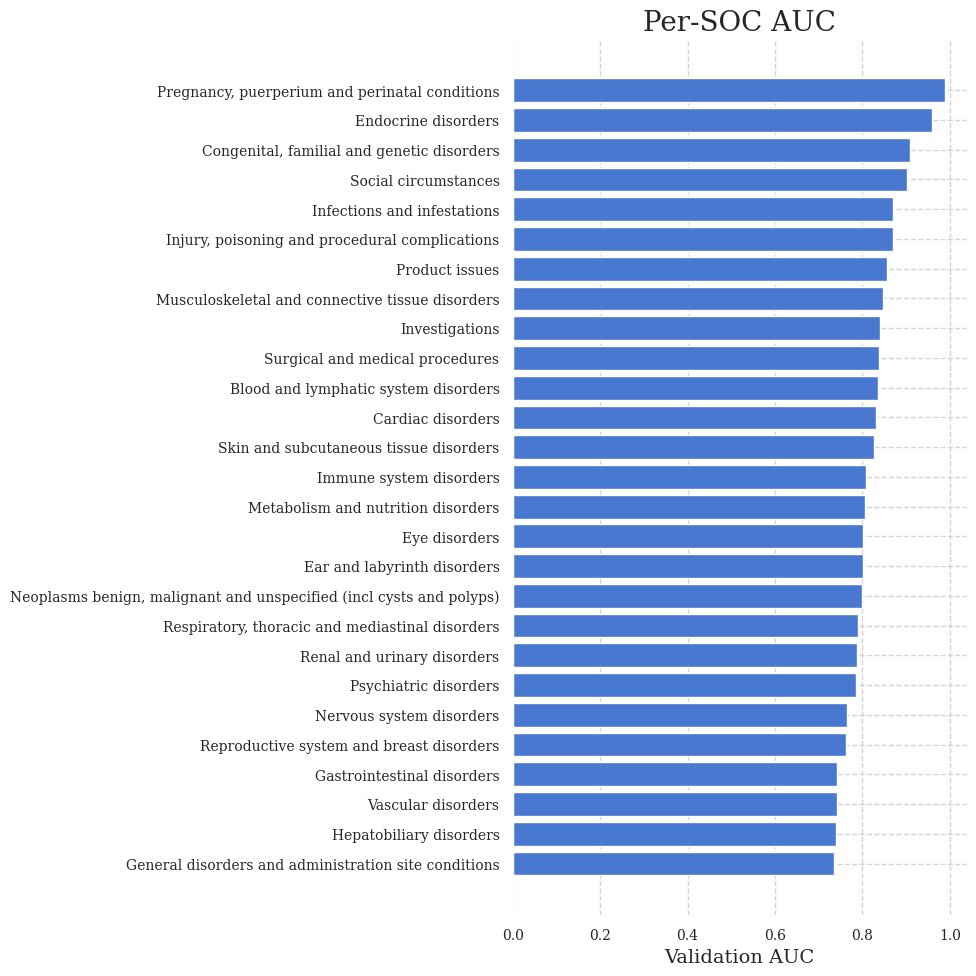

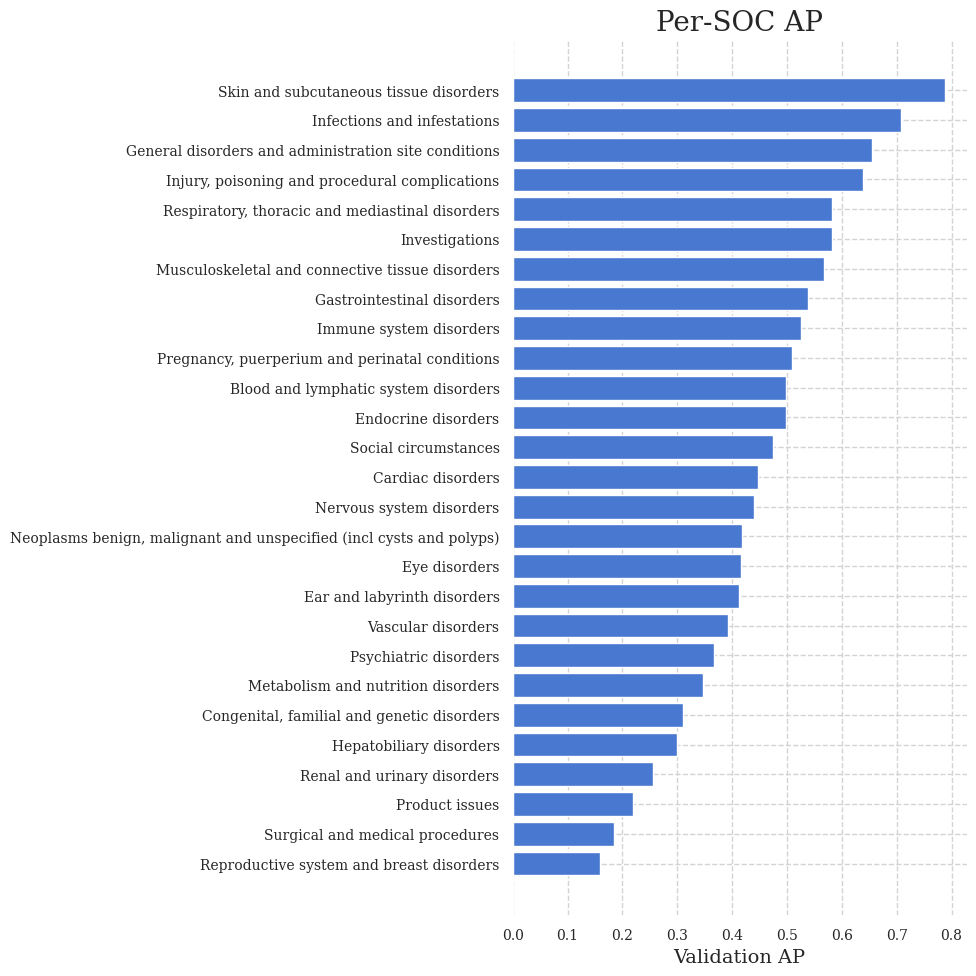

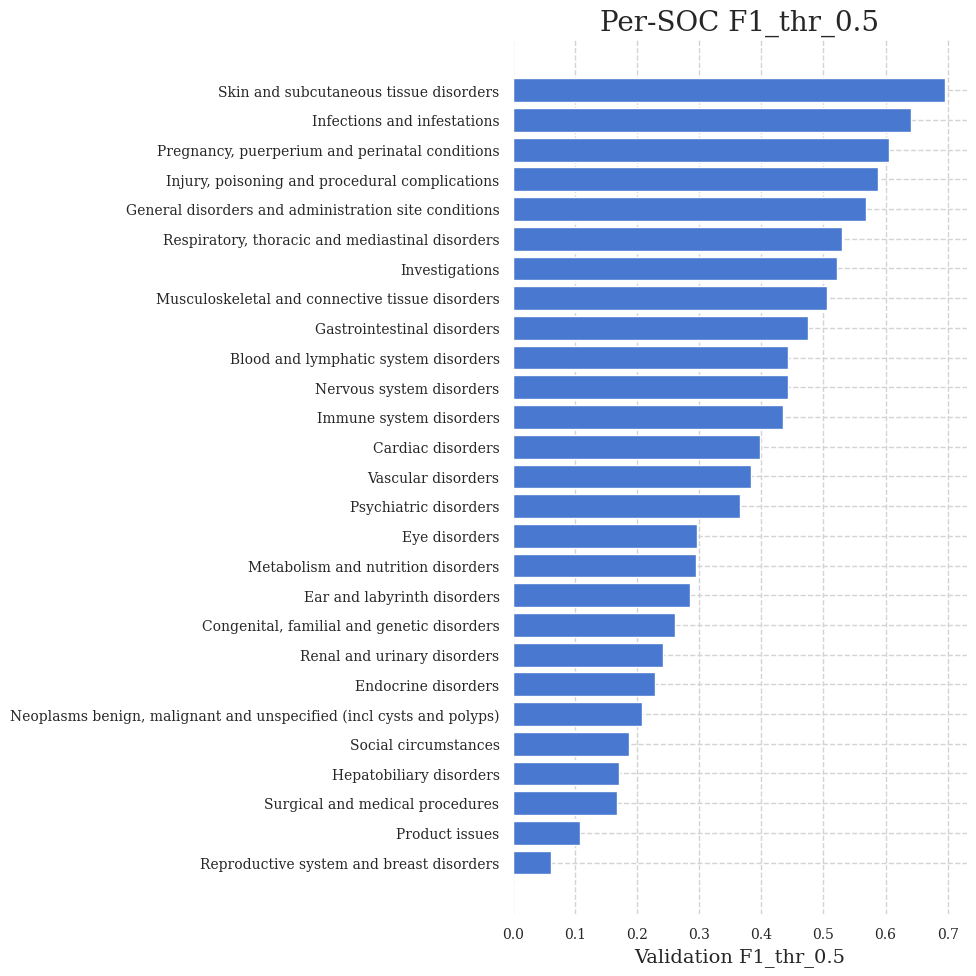

In [18]:
metrics = ["AUC", "AP", "F1_thr_0.5"]

for metric in metrics:

    plt.figure(figsize=(10, 10))
    order = metrics_df.sort_values(metric, ascending=False)["SOC"]

    plt.barh(
        y=range(len(order)),
        width=metrics_df.set_index("SOC").loc[order, metric]
    )
    plt.yticks(range(len(order)), order)
    plt.xlabel(f"Validation {metric}")
    plt.title(f"Per-SOC {metric}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# Validation

In [19]:
def predict_all_socs(models, soc_names, X):
    """
    Return DataFrame of P(SOC_k=1 | X) with shape (n_samples, K).
    """
    probs = {}
    for soc in soc_names:
        model_k = models[soc]
        probs[soc] = model_k.predict_proba(X)[:, 1]
    return pd.DataFrame(probs, index=X.index)

Y_valid_probs = predict_all_socs(models, soc_names, X_valid)

In [21]:
# Ground truth and predictions as numpy arrays
treshold = 0.75
Y_true = Y_valid[soc_names].values.astype(int)
Y_pred_05 = (Y_valid_probs[soc_names].values >= treshold).astype(int)

# Micro
micro_f1_05 = f1_score(Y_true, Y_pred_05, average="micro", zero_division=0)
print(f"Micro F1 (thr={treshold}): {micro_f1_05:.3f}")

# Macro
macro_f1_05 = f1_score(Y_true, Y_pred_05, average="macro", zero_division=0)
print(f"Macro F1 (thr={treshold}): {macro_f1_05:.3f}")

# the detection of false positives 
false_positives = np.sum((Y_pred_05 == 1) & (Y_true == 0))
print(f"False Positives (thr={treshold}): {false_positives}")

# FPR
false_positive_rate = false_positives / np.sum(Y_true == 0)
print(f"False Positive Rate (thr={treshold}): {false_positive_rate:.3f}")

# TNR
true_negatives = np.sum((Y_pred_05 == 0) & (Y_true == 0))
true_negative_rate = true_negatives / np.sum(Y_true == 0)
print(f"True Negative Rate (thr={treshold}): {true_negative_rate:.3f}")

# PPV
predicted_positives = np.sum(Y_pred_05 == 1)
if predicted_positives > 0:
    positive_predictive_value = np.sum((Y_pred_05 == 1) & (Y_true == 1)) / predicted_positives
else:
    positive_predictive_value = 0.0
print(f"Positive Predictive Value (thr={treshold}): {positive_predictive_value:.3f}")

# Accuracy
accuracy = accuracy_score(Y_true, Y_pred_05)
print(f"Accuracy (thr={treshold}): {accuracy:.3f}")

Micro F1 (thr=0.75): 0.455
Macro F1 (thr=0.75): 0.409
False Positives (thr=0.75): 687
False Positive Rate (thr=0.75): 0.016
True Negative Rate (thr=0.75): 0.984
Positive Predictive Value (thr=0.75): 0.696
Accuracy (thr=0.75): 0.139


Max FPR: 1.000, at threshold 0.000
Max TNR: 1.000, at threshold 1.000
Max PPV: 0.960, at threshold 0.990
Max Macro F1: 0.423, at threshold 0.697
Max Micro F1: 0.501, at threshold 0.586
Max Accuracy: 0.156, at threshold 0.626


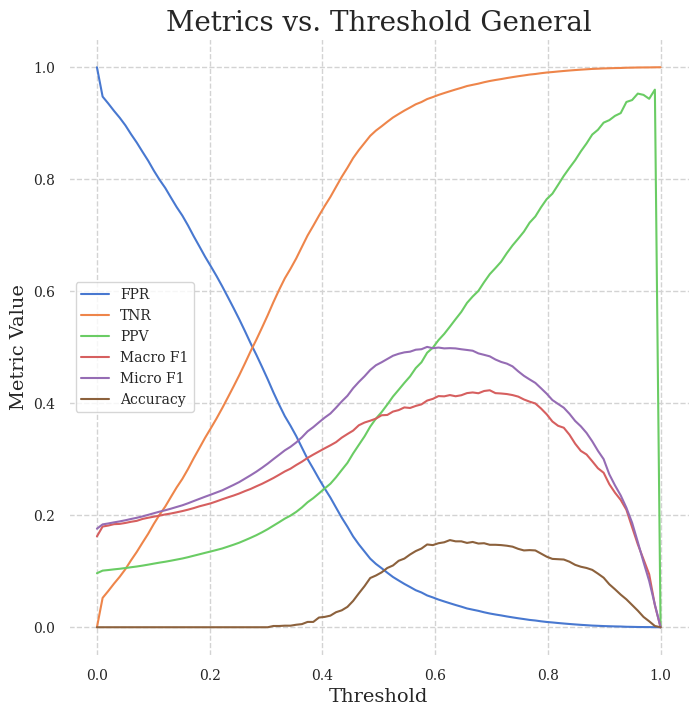

In [22]:
# plot how the FPR changes for each threshold
thresholds = np.linspace(0, 1, 100)

fpr_values = []
tnr_values = []
ppv_values = []
f1_macro_values = []
f1_micro_values = []
acc_values = []

for t in thresholds:
    Y_pred_t = (Y_valid_probs[soc_names].values >= t).astype(int)
    false_positives_t = np.sum((Y_pred_t == 1) & (Y_true == 0))
    fpr_t = false_positives_t / np.sum(Y_true == 0)
    true_negatives_t = np.sum((Y_pred_t == 0) & (Y_true == 0))
    tnr_t = true_negatives_t / np.sum(Y_true == 0)
    ppv_t = np.sum((Y_pred_t == 1) & (Y_true == 1)) / np.sum(Y_pred_t == 1) if np.sum(Y_pred_t == 1) > 0 else 0.0
    ppv_values.append(ppv_t)
    f1_macro_t = f1_score(Y_true, Y_pred_t, average="macro", zero_division=0)
    f1_micro_t = f1_score(Y_true, Y_pred_t, average="micro", zero_division=0)

    acc_t = accuracy_score(Y_true, Y_pred_t)
    acc_values.append(acc_t)
    fpr_values.append(fpr_t)
    f1_macro_values.append(f1_macro_t)
    f1_micro_values.append(f1_micro_t)
    tnr_values.append(tnr_t)

max_fpr = max(fpr_values)
max_tnr = max(tnr_values)
max_ppv = max(ppv_values)
max_f1_macro = max(f1_macro_values)
max_f1_micro = max(f1_micro_values)
max_acc = max(acc_values)

print(f"Max FPR: {max_fpr:.3f}, at threshold {thresholds[np.argmax(fpr_values)]:.3f}")
print(f"Max TNR: {max_tnr:.3f}, at threshold {thresholds[np.argmax(tnr_values)]:.3f}")
print(f"Max PPV: {max_ppv:.3f}, at threshold {thresholds[np.argmax(ppv_values)]:.3f}")
print(f"Max Macro F1: {max_f1_macro:.3f}, at threshold {thresholds[np.argmax(f1_macro_values)]:.3f}")
print(f"Max Micro F1: {max_f1_micro:.3f}, at threshold {thresholds[np.argmax(f1_micro_values)]:.3f}")
print(f"Max Accuracy: {max_acc:.3f}, at threshold {thresholds[np.argmax(acc_values)]:.3f}")

plt.plot(thresholds, fpr_values, label="FPR")
plt.plot(thresholds, tnr_values, label="TNR")
plt.plot(thresholds, ppv_values, label="PPV")
plt.plot(thresholds, f1_macro_values, label="Macro F1")
plt.plot(thresholds, f1_micro_values, label="Micro F1")
plt.plot(thresholds, acc_values, label="Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs. Threshold General")
plt.legend()
plt.show()

## Best treshold for each one

In [23]:
def best_threshold_for_f1(y_true, y_prob, n_grid=101):
    """
    Scan thresholds in [0,1] and return (best_tau, best_f1).
    Uses F1-score.
    """
    thresholds = np.linspace(0.0, 1.0, n_grid)
    best_tau = 0.5
    best_f1 = -1.0
    for tau in thresholds:
        y_pred = (y_prob >= tau).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_tau = tau
    return best_tau, best_f1

# Find per-SOC optimal thresholds on the validation data
best_taus = {}
best_f1s = {}

for j, soc in enumerate(soc_names):
    y_true_k = Y_valid[soc].values.astype(int)
    y_prob_k = Y_valid_probs[soc].values
    tau_k, f1_k = best_threshold_for_f1(y_true_k, y_prob_k, n_grid=101)
    best_taus[soc] = tau_k
    best_f1s[soc] = f1_k

best_thresholds_df = (
    pd.DataFrame({"SOC": soc_names, "best_tau": [best_taus[s] for s in soc_names],
                  "best_F1":  [best_f1s[s] for s in soc_names]})
    .set_index("SOC")
)
best_thresholds_df


best_tau   best_F1
SOC                                                                   
Blood and lymphatic system disorders                    0.57  0.477212
Cardiac disorders                                       0.74  0.415584
Congenital, familial and genetic disorders              0.47  0.333333
Ear and labyrinth disorders                             0.85  0.454545
Endocrine disorders                                     0.76  0.588235
Eye disorders                                           0.79  0.461538
Gastrointestinal disorders                              0.53  0.494700
General disorders and administration site condi...      0.41  0.573048
Hepatobiliary disorders                                 0.72  0.421053
Immune system disorders                                 0.66  0.496000
Infections and infestations                             0.59  0.665800
Injury, poisoning and procedural complications          0.61  0.620525
Investigations                                          0.54  0.533333
Metabolism and nutrition disorders                      0.68  0.338798
Musculoskeletal and connective tissue disorders         0.68  0.541568
Neoplasms benign, malignant and unspecified (in...      0.80  0.500000
Nervous system disorders                                0.50  0.443411
Pregnancy, puerperium and perinatal conditions          0.60  0.625000
Product issues                                          0.67  0.285714
Psychiatric disorders                                   0.57  0.401460
Renal and urinary disorders                             0.58  0.282132
Reproductive system and breast disorders                0.70  0.200000
Respiratory, thoracic and mediastinal disorders         0.54  0.530920
Skin and subcutaneous tissue disorders                  0.44  0.705121
Social circumstances                                    0.75  0.571429
Surgical and medical procedures                         0.72  0.281690
Vascular disorders                                      0.68  0.402778

In [24]:
# Apply SOC-specific thresholds
Y_pred_custom = np.zeros_like(Y_true, dtype=int)

for j, soc in enumerate(soc_names):
    tau_k = best_taus[soc]
    Y_pred_custom[:, j] = (Y_valid_probs[soc].values >= tau_k).astype(int)

micro_f1_custom = f1_score(Y_true, Y_pred_custom, average="micro", zero_division=0)
macro_f1_custom = f1_score(Y_true, Y_pred_custom, average="macro", zero_division=0)

print(f"Micro F1 (SOC-specific tau): {micro_f1_custom:.3f}")
print(f"Macro F1 (SOC-specific tau): {macro_f1_custom:.3f}")

Micro F1 (SOC-specific tau): 0.544
Macro F1 (SOC-specific tau): 0.468


# Feature importance using PredictionValuesChange

In [25]:
# feature_importances: DataFrame (SOC × feature)
feature_importances = pd.DataFrame(
    0.0,
    index=soc_names,
    columns=feature_names
)

for soc in soc_names:
    model_k = models[soc]
    # Default feature importance; you can also use type="PredictionValuesChange"
    imp_k = model_k.get_feature_importance(type="FeatureImportance")
    feature_importances.loc[soc, :] = imp_k

# drop if all the columnss are close to zero
feature_importances = feature_importances.loc[:, (feature_importances.abs() > 1).any(axis=0)]
feature_importances


AGE_Y  WEIGHT_KG  \
Blood and lymphatic system disorders                 6.016779   4.327671   
Cardiac disorders                                    7.083721   5.294704   
Congenital, familial and genetic disorders          11.088504   5.123962   
Ear and labyrinth disorders                         10.847585   5.648786   
Endocrine disorders                                  8.578439   3.035498   
Eye disorders                                       10.440441   5.903784   
Gastrointestinal disorders                           6.074169   4.725967   
General disorders and administration site condi...   6.418005   4.449313   
Hepatobiliary disorders                              6.522836   4.885256   
Immune system disorders                              7.979424   5.738144   
Infections and infestations                          5.644160   2.991705   
Injury, poisoning and procedural complications       6.021571   5.950031   
Investigations                                       4.750409   3.081909   
Metabolism and nutrition disorders                   3.241575   4.001460   
Musculoskeletal and connective tissue disorders      6.778530   5.713748   
Neoplasms benign, malignant and unspecified (in...   8.426706   5.997468   
Nervous system disorders                             6.663178   6.386258   
Pregnancy, puerperium and perinatal conditions      20.424723  13.260459   
Product issues                                       1.362934   3.267953   
Psychiatric disorders                                4.402407   2.041473   
Renal and urinary disorders                          5.343646   4.899388   
Reproductive system and breast disorders            15.338925   5.895026   
Respiratory, thoracic and mediastinal disorders      2.925395   3.738040   
Skin and subcutaneous tissue disorders               3.767761   4.440022   
Social circumstances                                 4.421623   4.054347   
Surgical and medical procedures                      1.251211   2.184087   
Vascular disorders                                   3.325055   6.190641   

                                                    HEIGHT_CM  GENDER_CODE  \
Blood and lymphatic system disorders                 3.414008     1.358409   
Cardiac disorders                                    5.758272     0.336302   
Congenital, familial and genetic disorders           5.207362     0.665631   
Ear and labyrinth disorders                          6.748782     0.128885   
Endocrine disorders                                  1.107419     0.000000   
Eye disorders                                        8.103236     0.116239   
Gastrointestinal disorders                           5.816325     0.546033   
General disorders and administration site condi...   3.984461     0.178907   
Hepatobiliary disorders                              4.667904     0.177690   
Immune system disorders                              5.540709     0.411799   
Infections and infestations                          2.969999     0.368282   
Injury, poisoning and procedural complications       4.817039     0.232177   
Investigations                                       2.501808     0.095147   
Metabolism and nutrition disorders                   2.608880     0.324822   
Musculoskeletal and connective tissue disorders      4.716992     0.333138   
Neoplasms benign, malignant and unspecified (in...   2.247605     0.283724   
Nervous system disorders                             4.881926     0.079087   
Pregnancy, puerperium and perinatal conditions      10.623197     3.776194   
Product issues                                       2.245220     0.000000   
Psychiatric disorders                                2.296588     0.000000   
Renal and urinary disorders                          1.935484     0.318433   
Reproductive system and breast disorders             6.393098     0.822797   
Respiratory, thoracic and mediastinal disorders      2.496754     0.172650   
Skin and subcutaneous tissue disorders               4.

In [26]:
feature_importances_pvc = pd.DataFrame(
    0.0,
    index=soc_names,
    columns=feature_names
)

for soc in soc_names:
    model_k = models[soc]
    imp_k = model_k.get_feature_importance(type="PredictionValuesChange")
    feature_importances_pvc.loc[soc, :] = imp_k

feature_importances_pvc

AGE_Y  WEIGHT_KG  \
Blood and lymphatic system disorders                 6.016779   4.327671   
Cardiac disorders                                    7.083721   5.294704   
Congenital, familial and genetic disorders          11.088504   5.123962   
Ear and labyrinth disorders                         10.847585   5.648786   
Endocrine disorders                                  8.578439   3.035498   
Eye disorders                                       10.440441   5.903784   
Gastrointestinal disorders                           6.074169   4.725967   
General disorders and administration site condi...   6.418005   4.449313   
Hepatobiliary disorders                              6.522836   4.885256   
Immune system disorders                              7.979424   5.738144   
Infections and infestations                          5.644160   2.991705   
Injury, poisoning and procedural complications       6.021571   5.950031   
Investigations                                       4.750409   3.081909   
Metabolism and nutrition disorders                   3.241575   4.001460   
Musculoskeletal and connective tissue disorders      6.778530   5.713748   
Neoplasms benign, malignant and unspecified (in...   8.426706   5.997468   
Nervous system disorders                             6.663178   6.386258   
Pregnancy, puerperium and perinatal conditions      20.424723  13.260459   
Product issues                                       1.362934   3.267953   
Psychiatric disorders                                4.402407   2.041473   
Renal and urinary disorders                          5.343646   4.899388   
Reproductive system and breast disorders            15.338925   5.895026   
Respiratory, thoracic and mediastinal disorders      2.925395   3.738040   
Skin and subcutaneous tissue disorders               3.767761   4.440022   
Social circumstances                                 4.421623   4.054347   
Surgical and medical procedures                      1.251211   2.184087   
Vascular disorders                                   3.325055   6.190641   

                                                    HEIGHT_CM  GENDER_CODE  \
Blood and lymphatic system disorders                 3.414008     1.358409   
Cardiac disorders                                    5.758272     0.336302   
Congenital, familial and genetic disorders           5.207362     0.665631   
Ear and labyrinth disorders                          6.748782     0.128885   
Endocrine disorders                                  1.107419     0.000000   
Eye disorders                                        8.103236     0.116239   
Gastrointestinal disorders                           5.816325     0.546033   
General disorders and administration site condi...   3.984461     0.178907   
Hepatobiliary disorders                              4.667904     0.177690   
Immune system disorders                              5.540709     0.411799   
Infections and infestations                          2.969999     0.368282   
Injury, poisoning and procedural complications       4.817039     0.232177   
Investigations                                       2.501808     0.095147   
Metabolism and nutrition disorders                   2.608880     0.324822   
Musculoskeletal and connective tissue disorders      4.716992     0.333138   
Neoplasms benign, malignant and unspecified (in...   2.247605     0.283724   
Nervous system disorders                             4.881926     0.079087   
Pregnancy, puerperium and perinatal conditions      10.623197     3.776194   
Product issues                                       2.245220     0.000000   
Psychiatric disorders                                2.296588     0.000000   
Renal and urinary disorders                          1.935484     0.318433   
Reproductive system and breast disorders             6.393098     0.822797   
Respiratory, thoracic and mediastinal disorders      2.496754     0.172650   
Skin and subcutaneous tissue disorders               4.

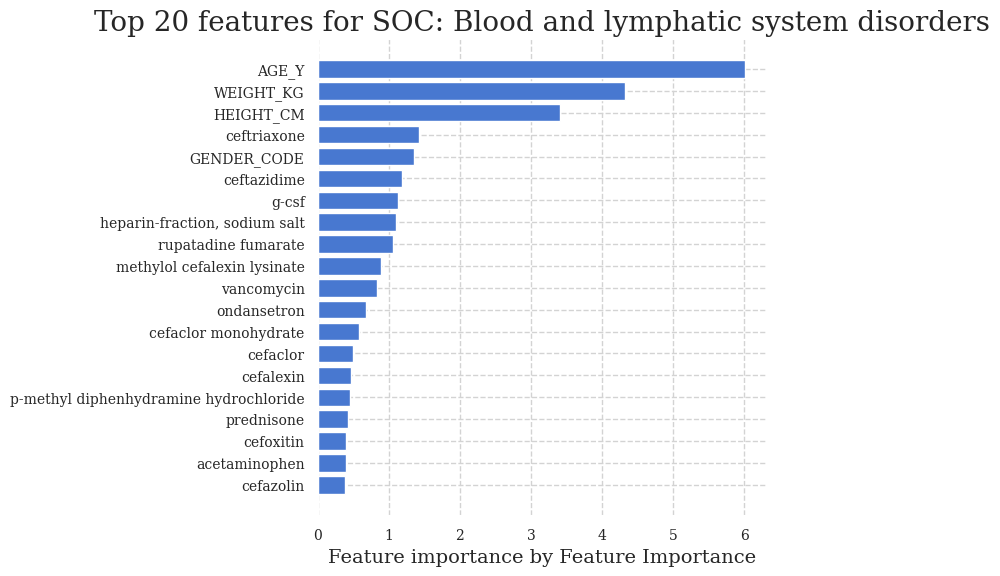

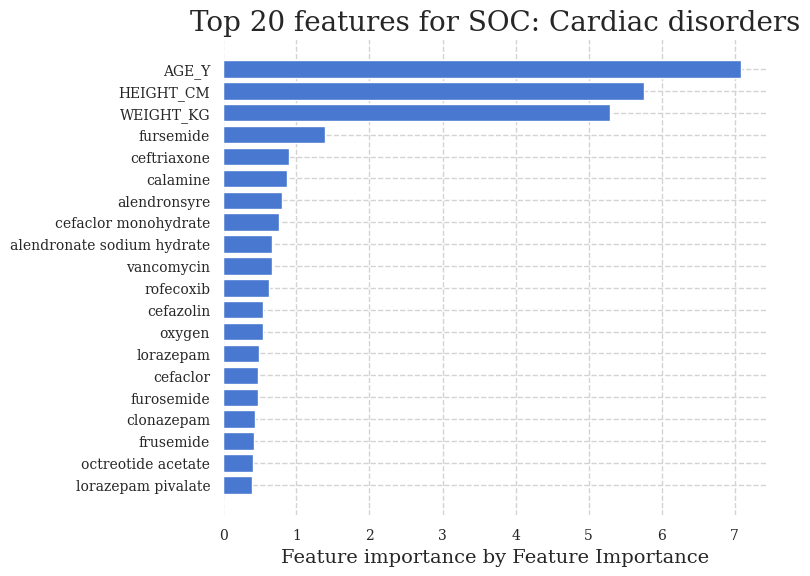

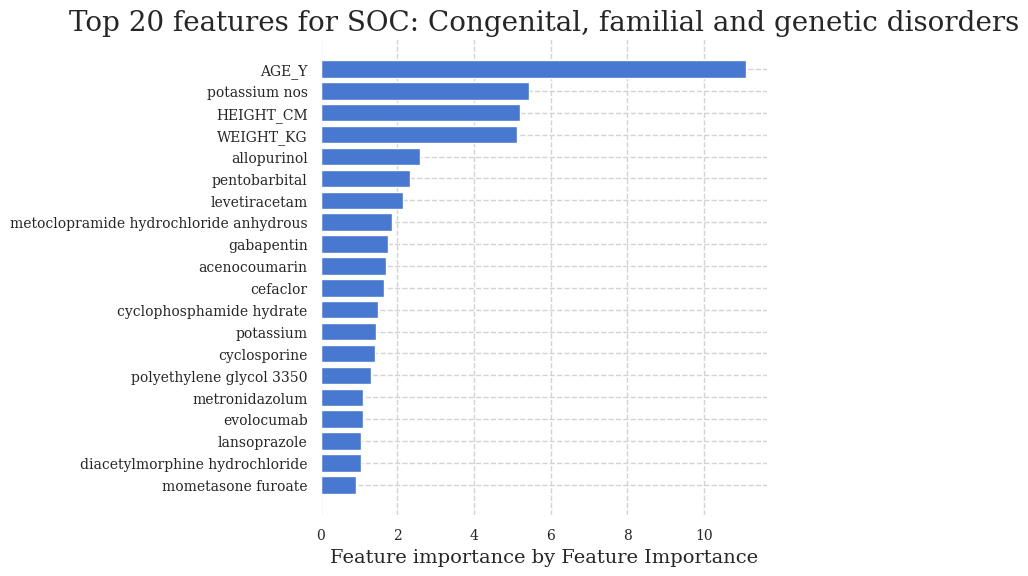

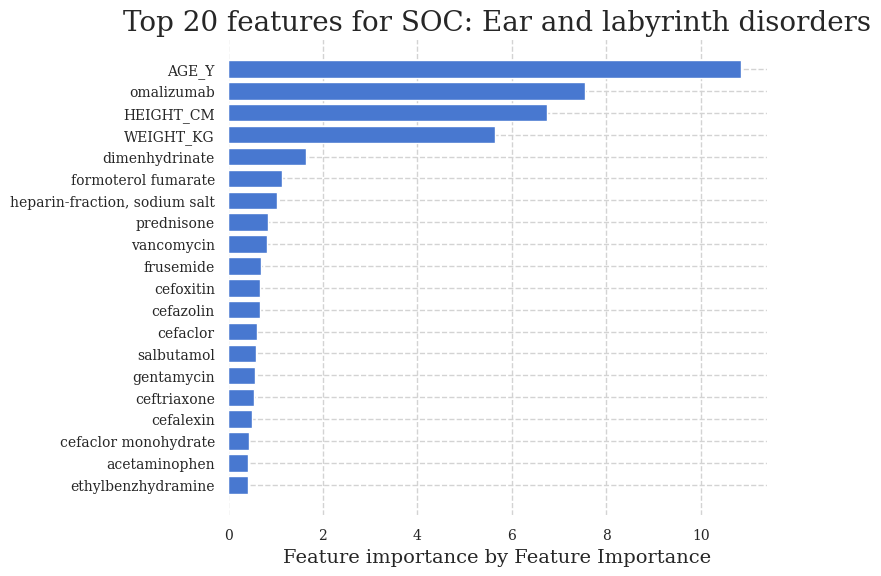

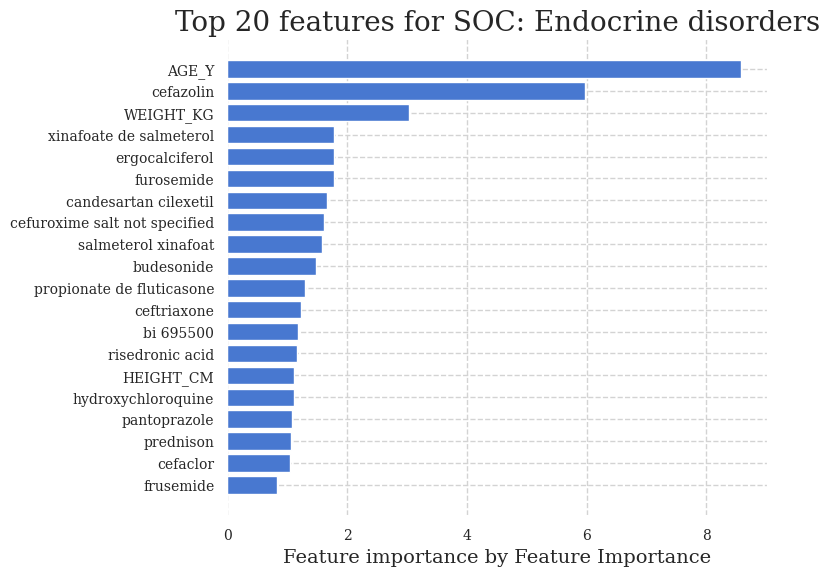

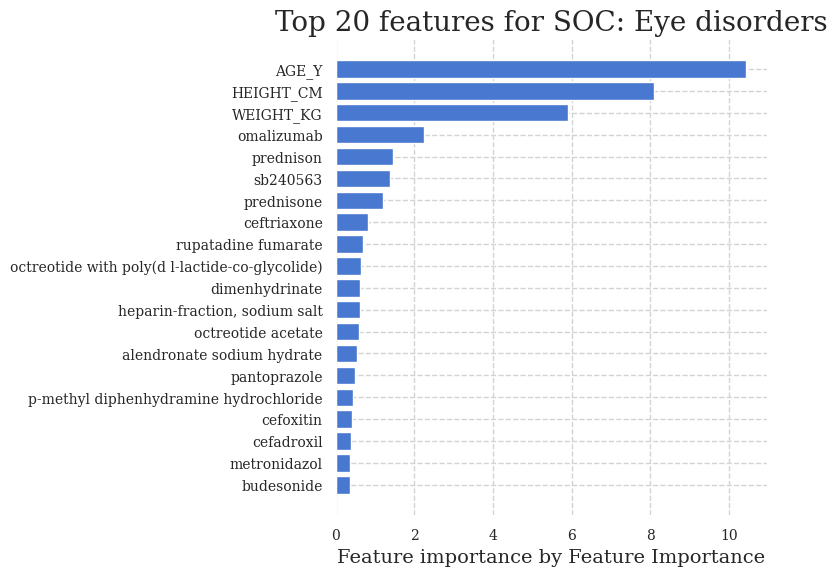

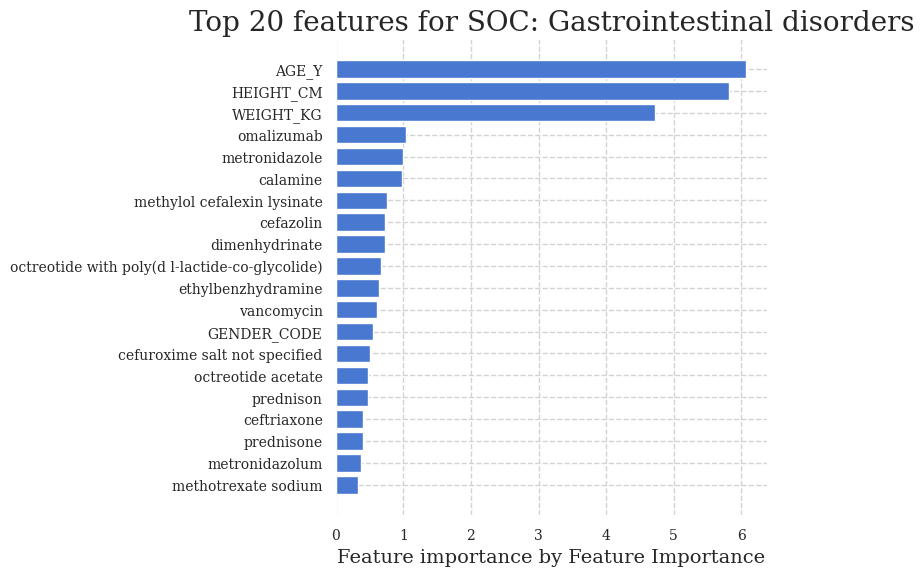

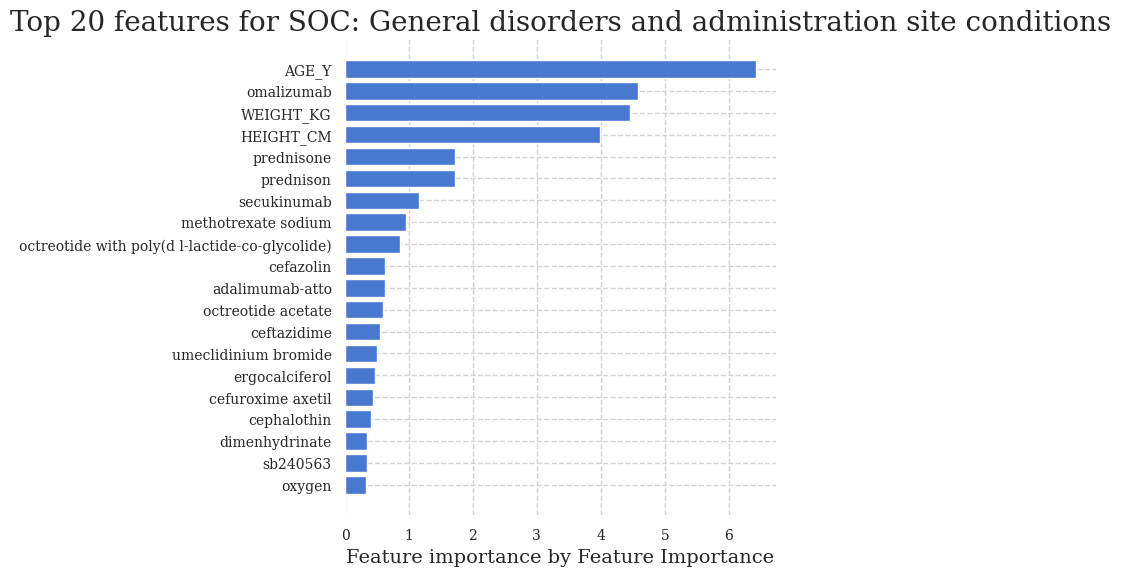

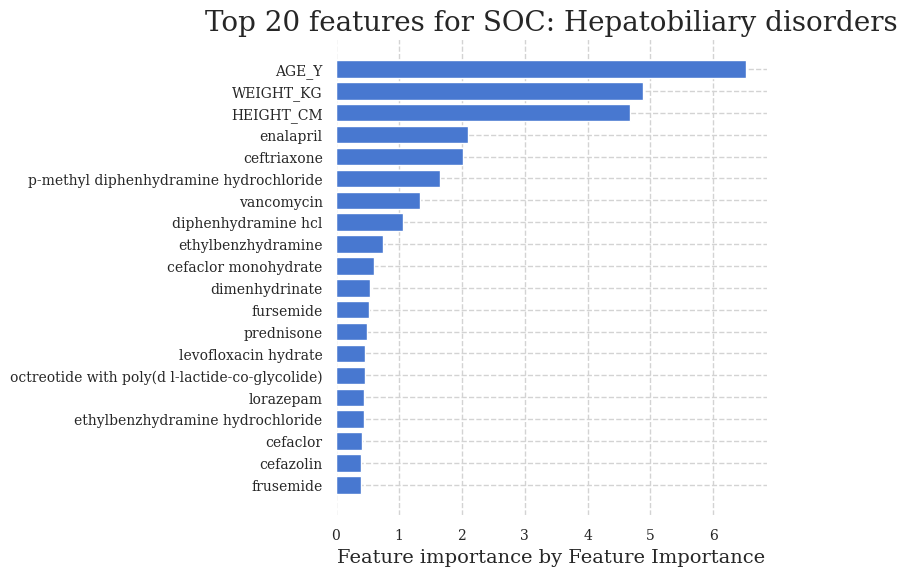

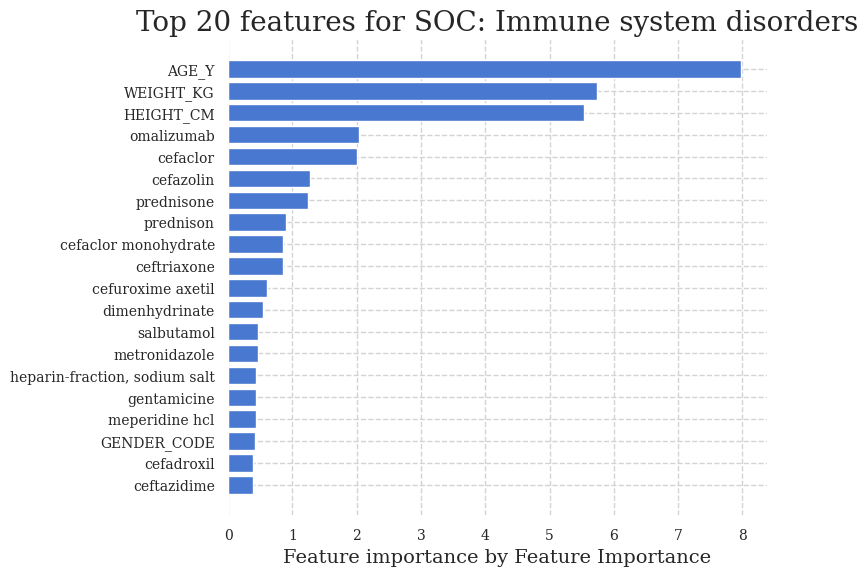

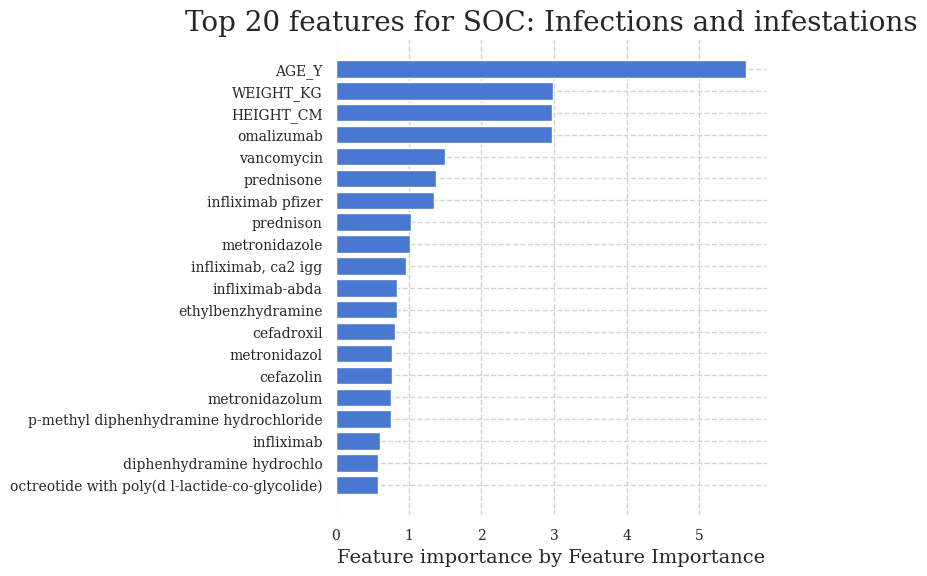

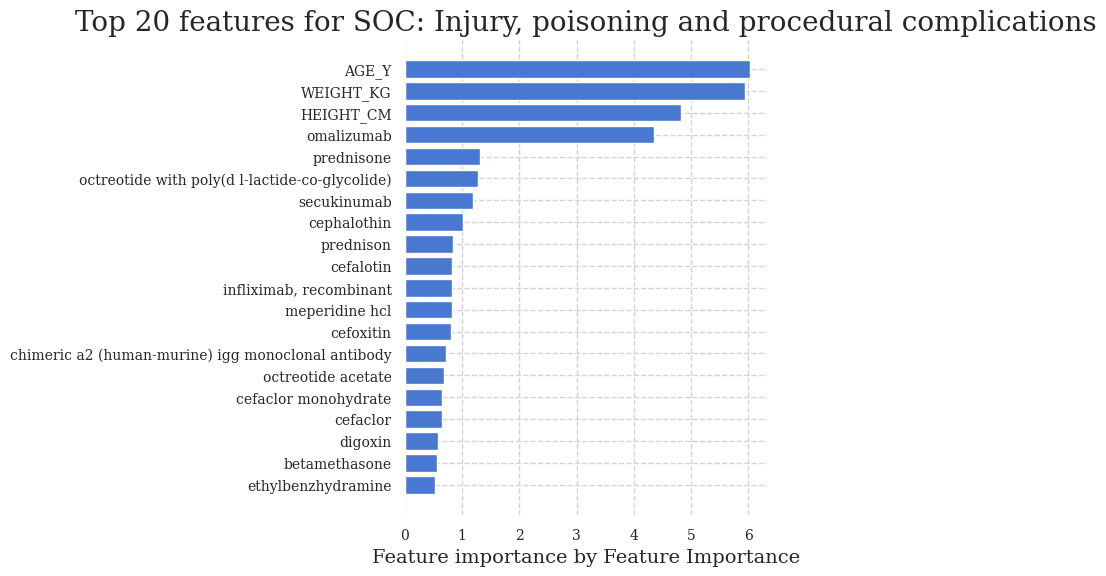

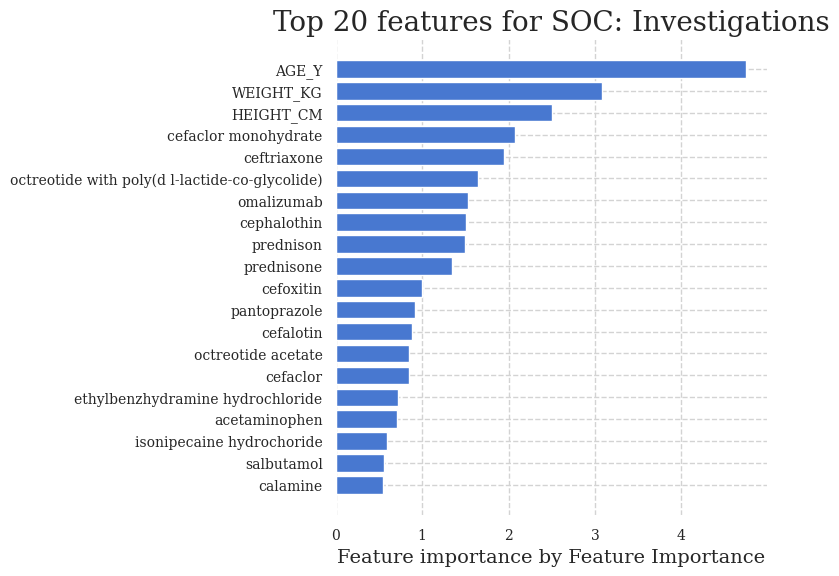

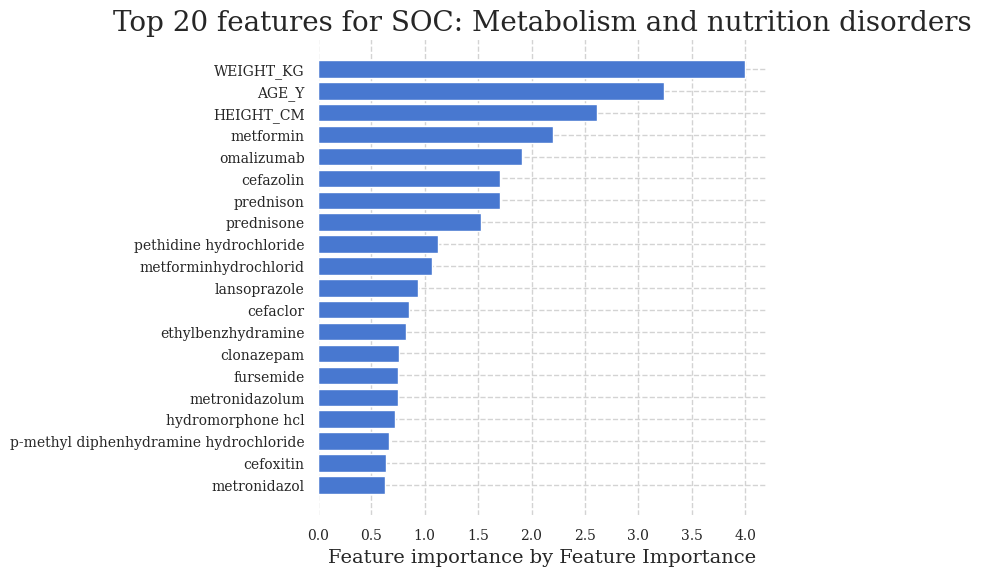

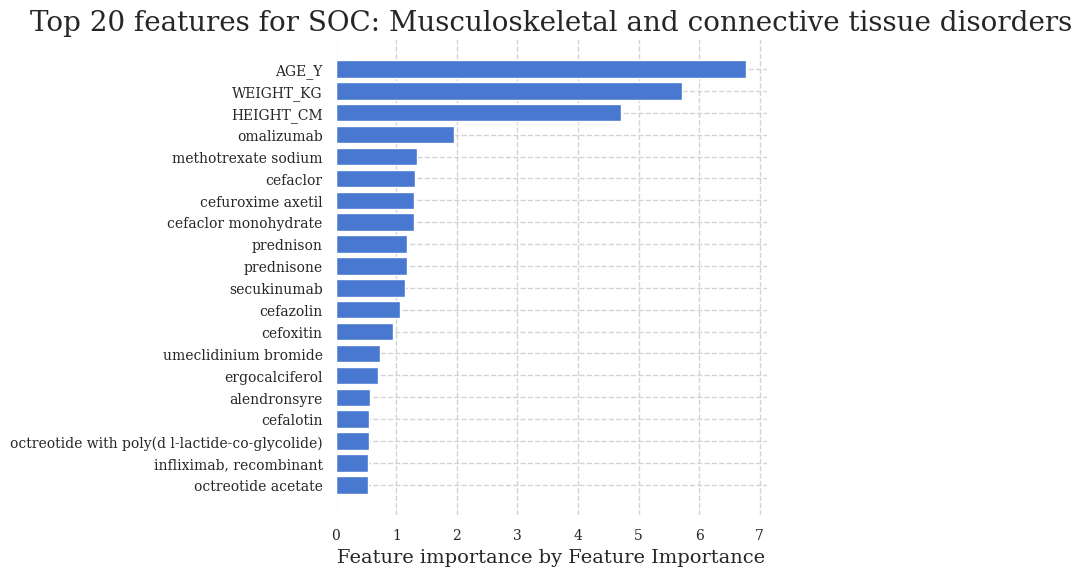

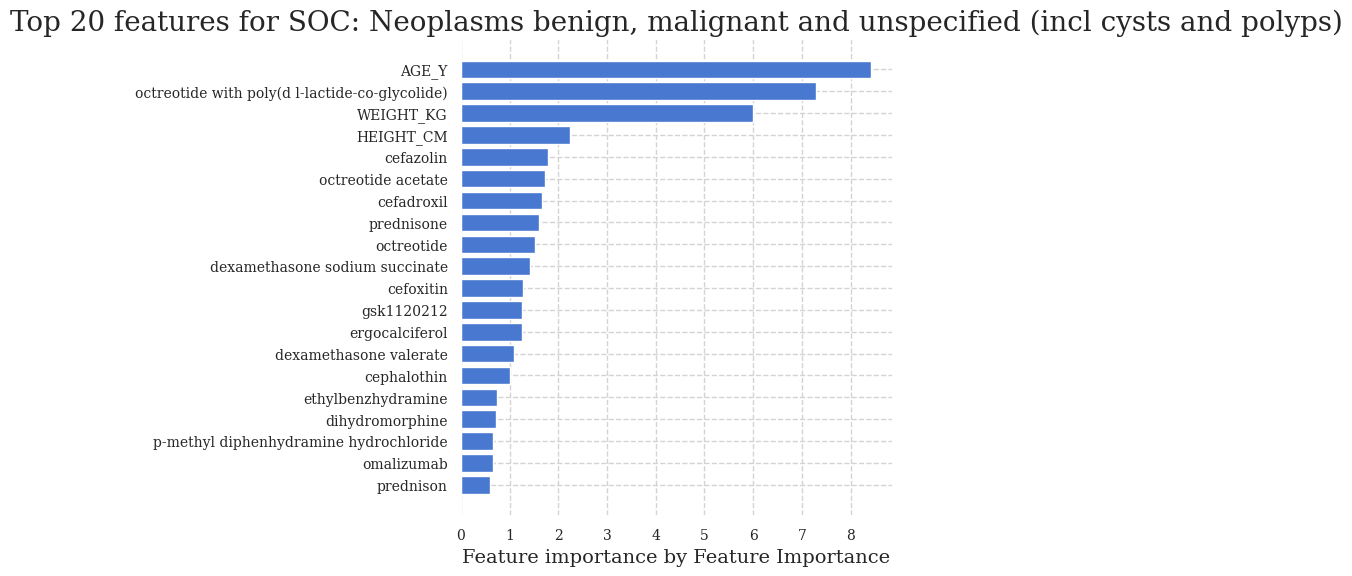

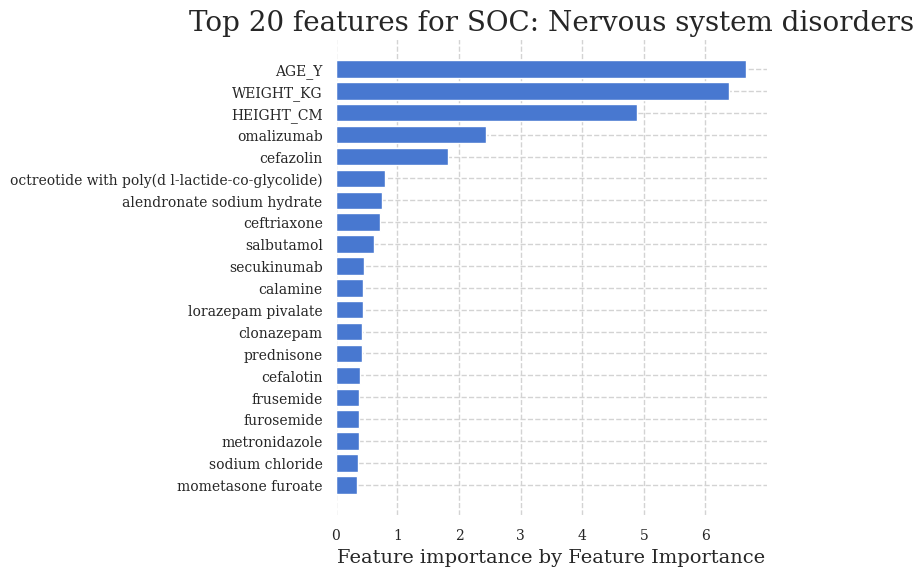

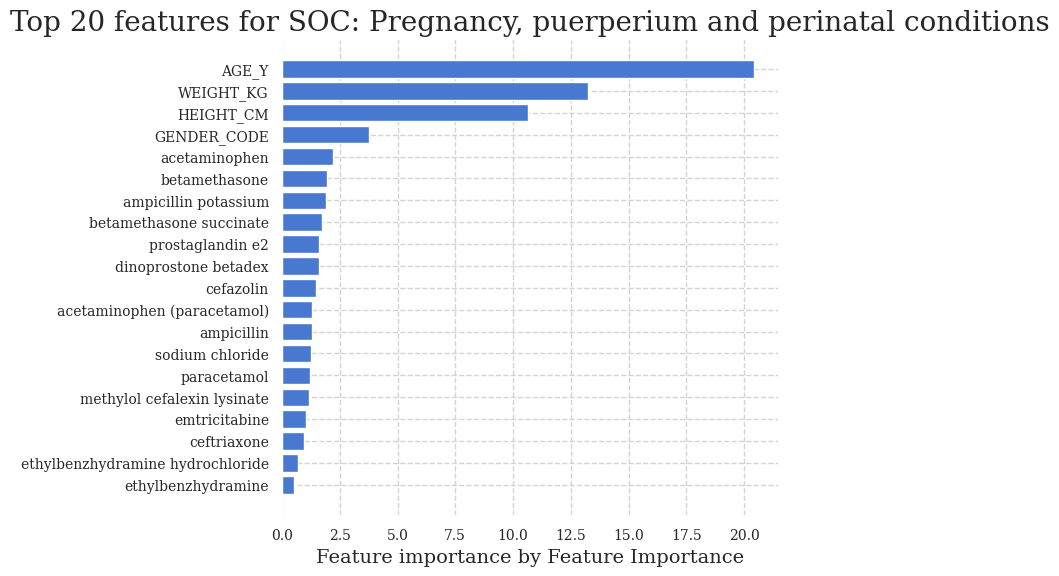

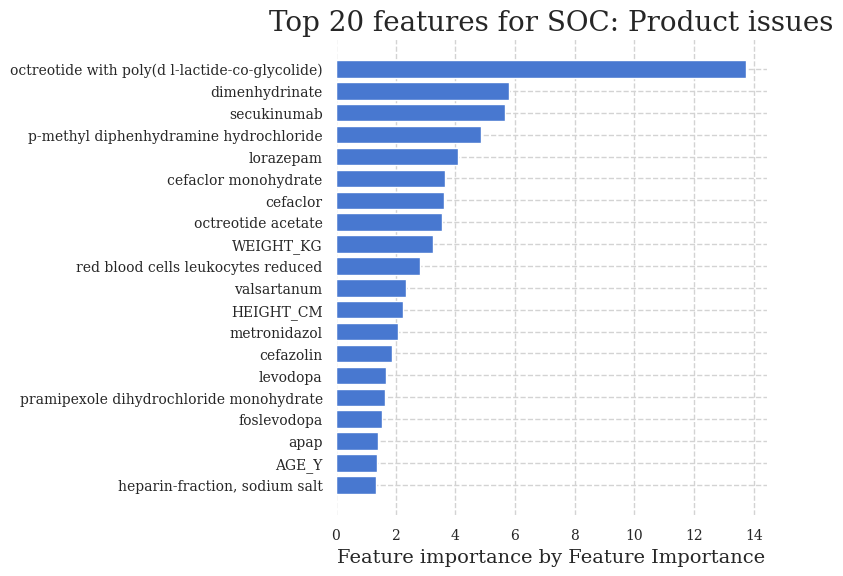

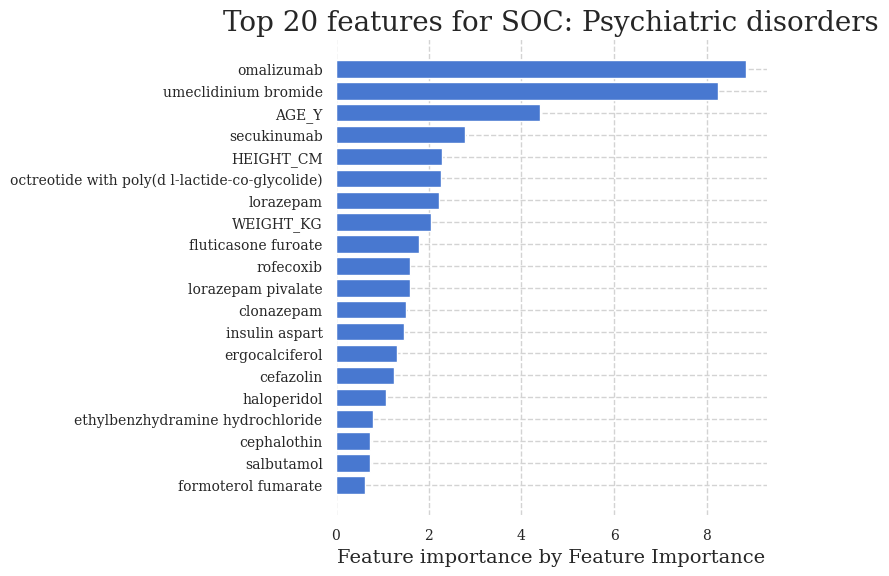

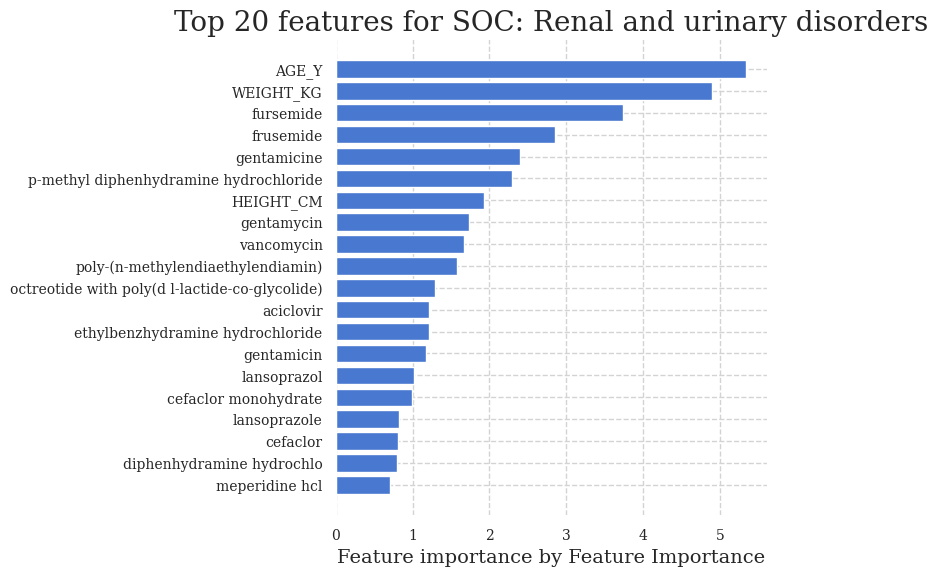

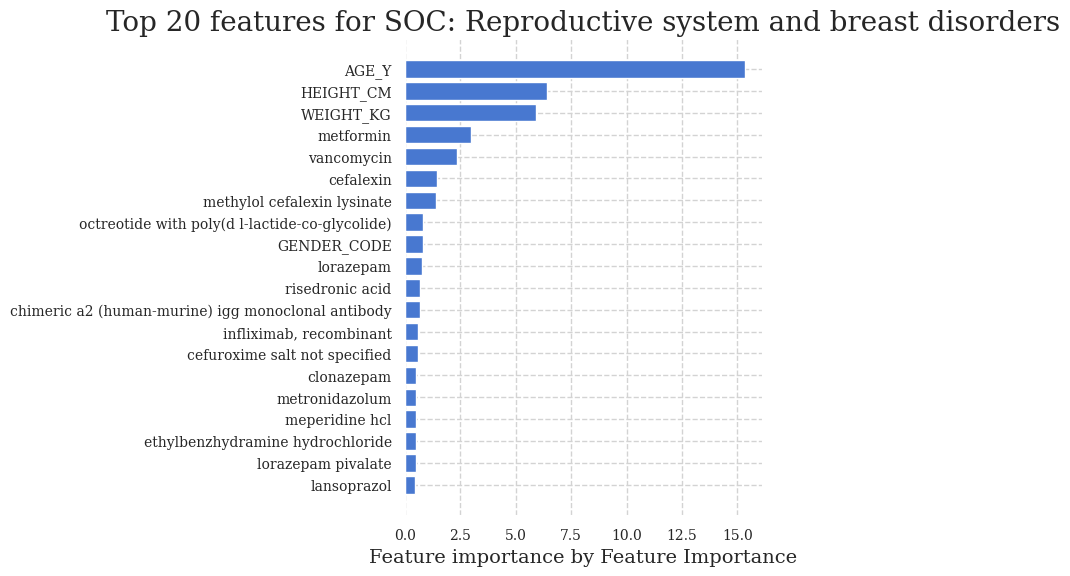

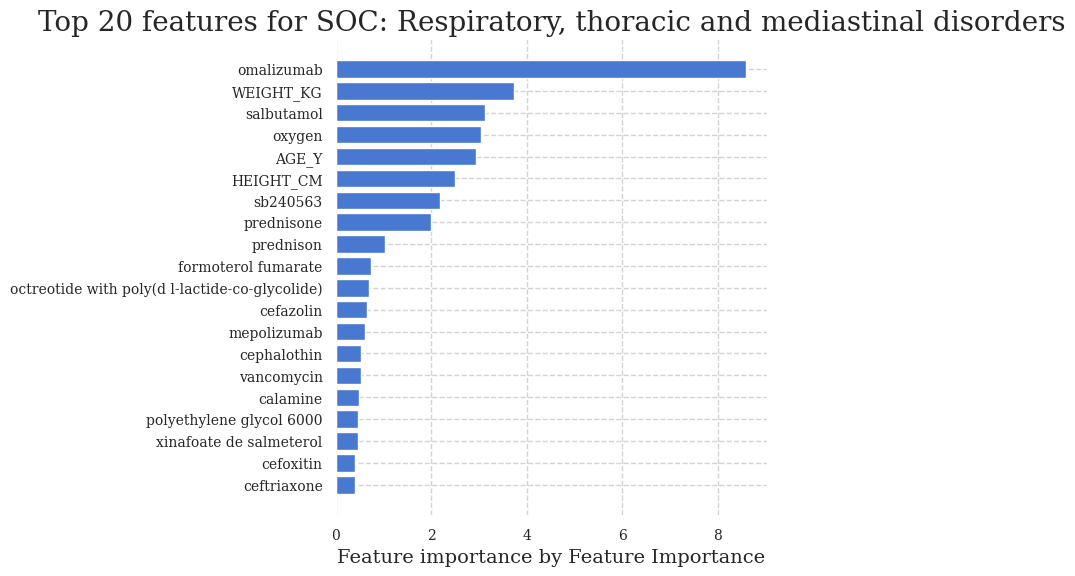

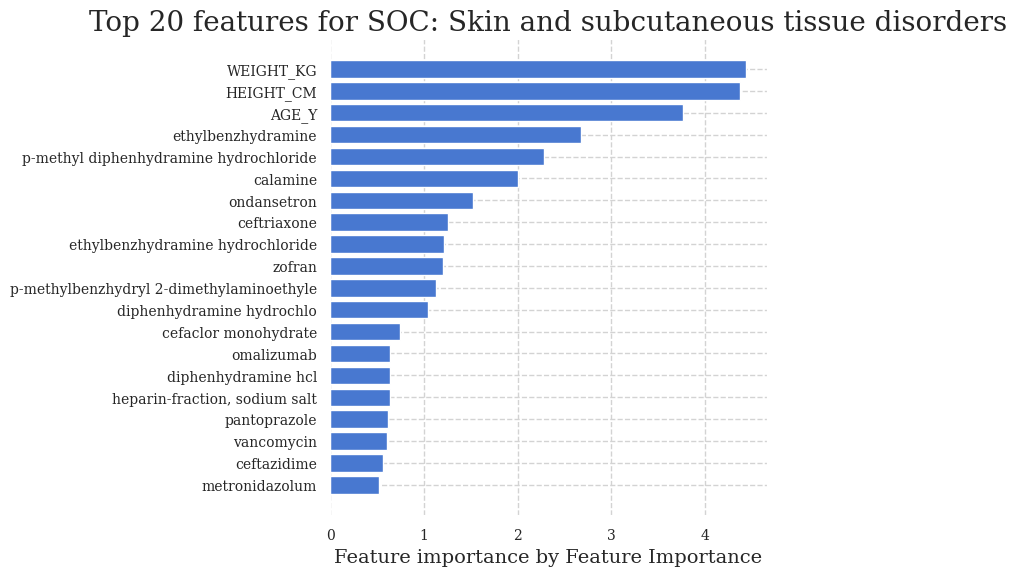

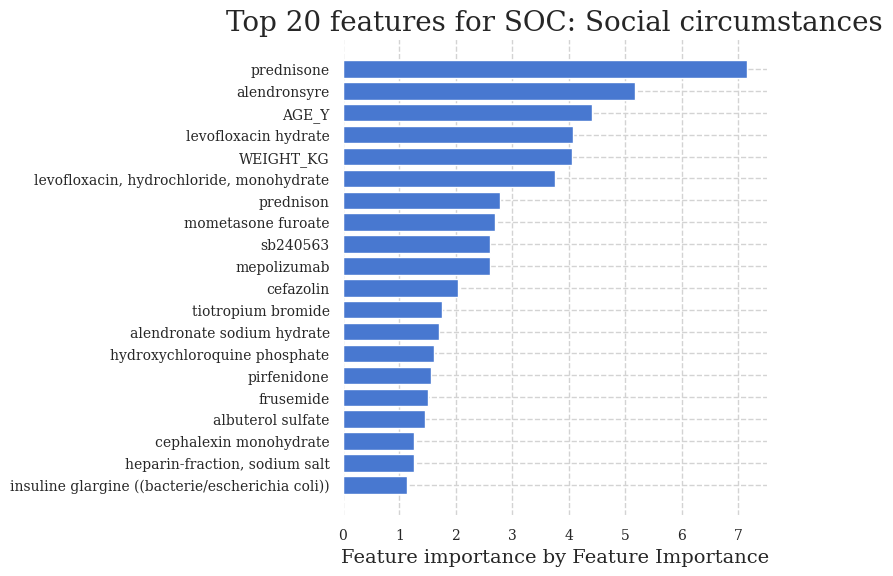

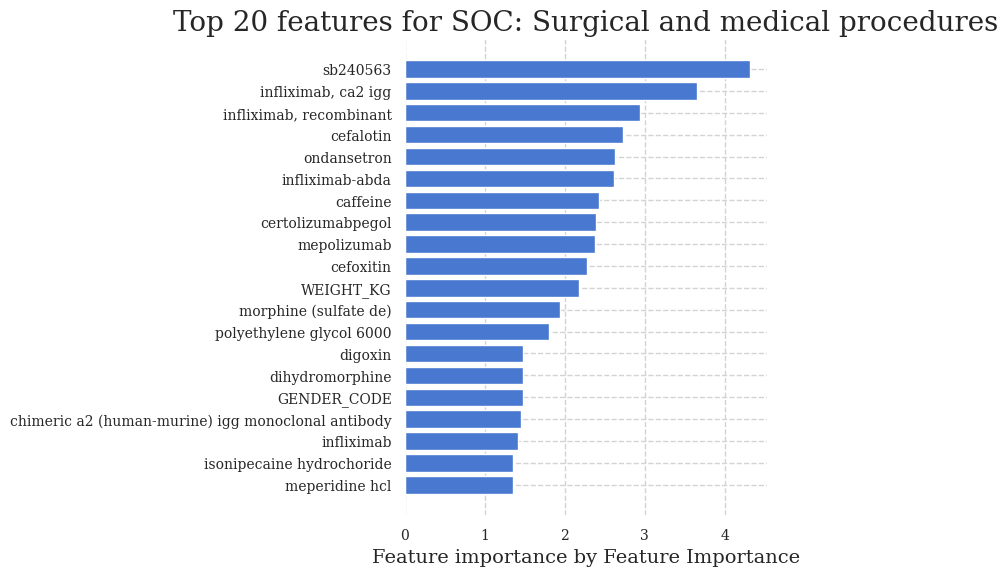

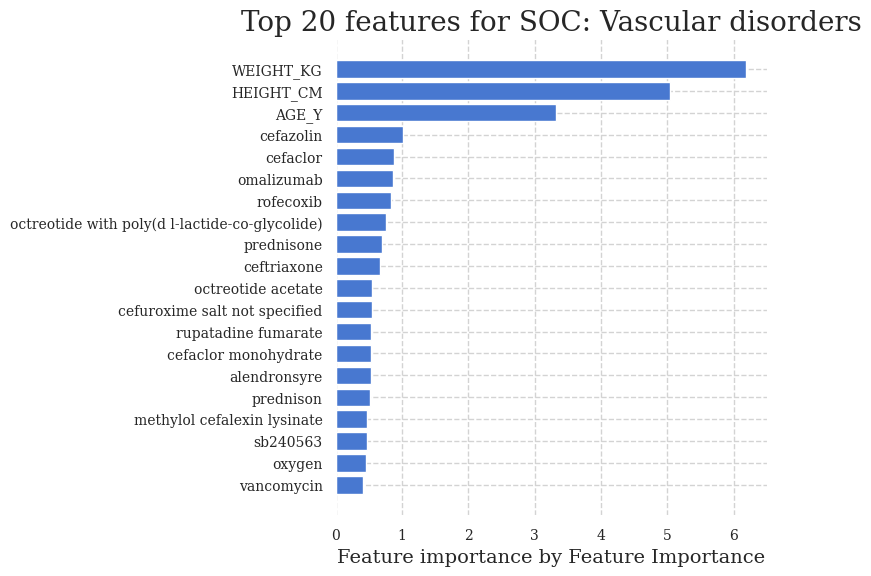

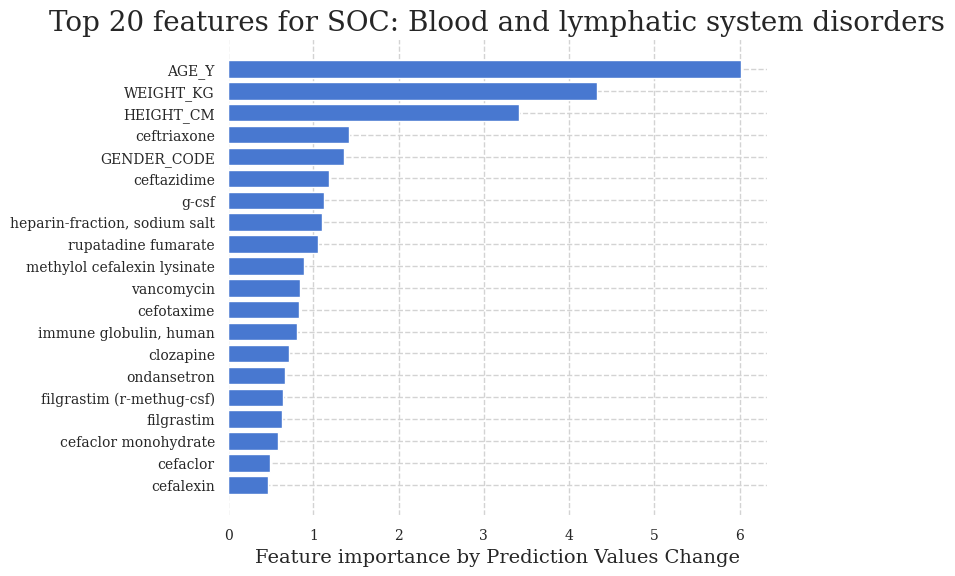

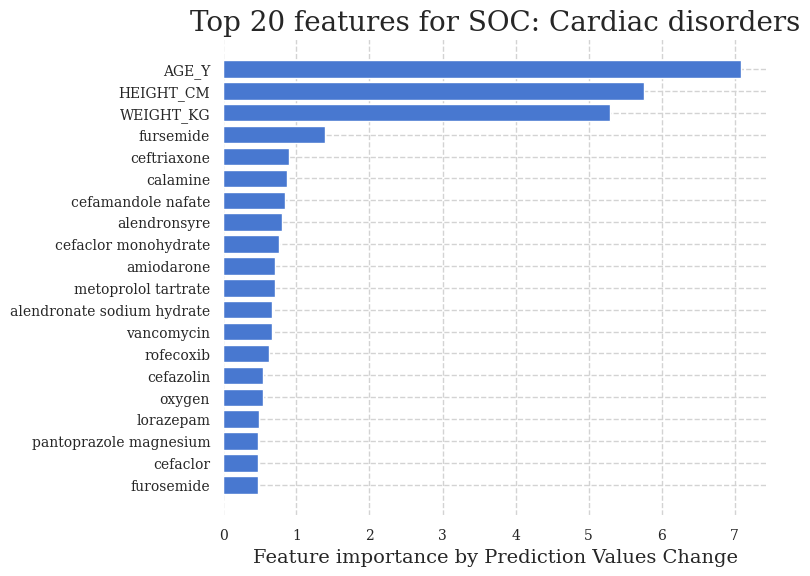

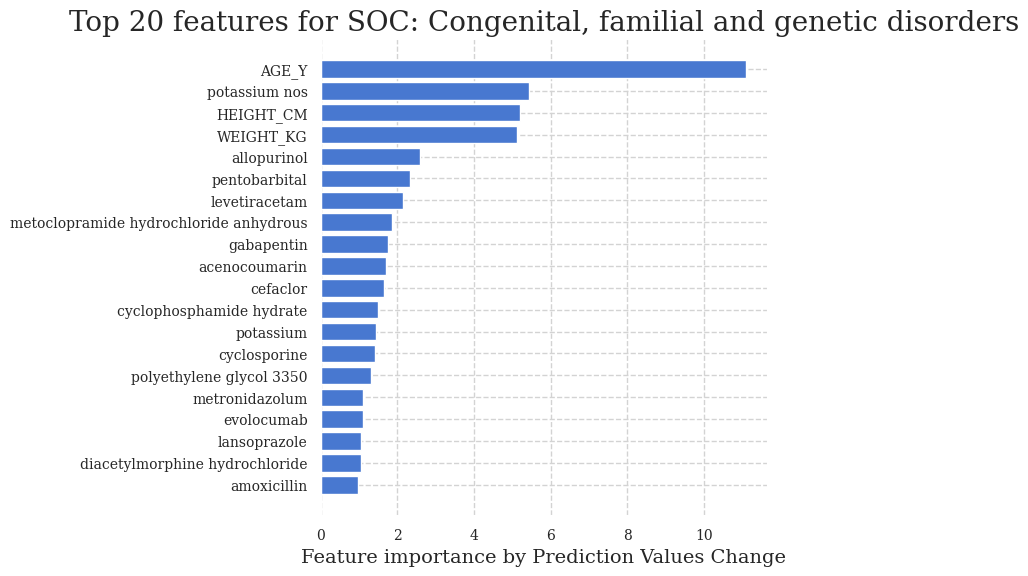

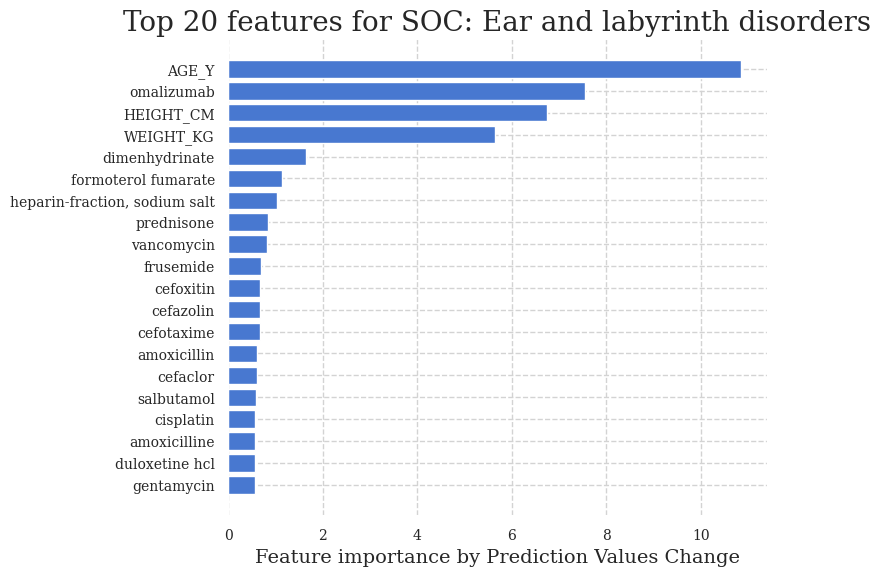

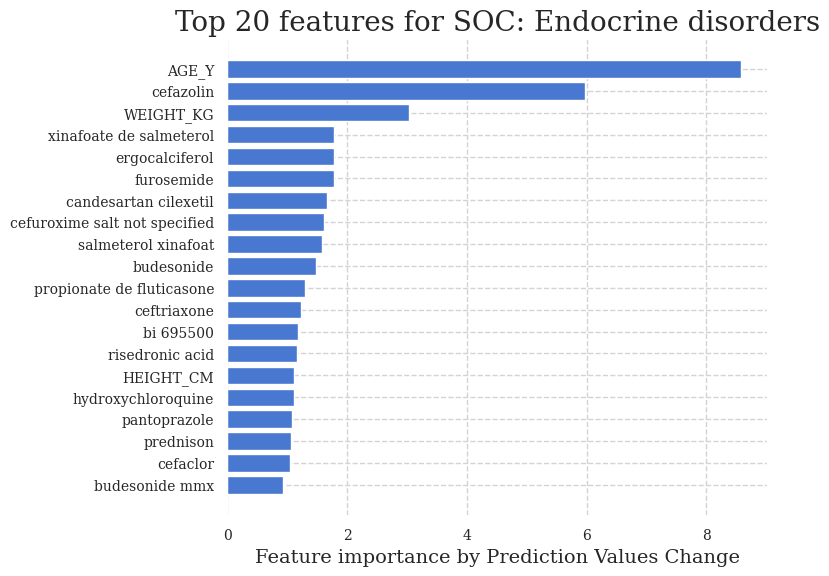

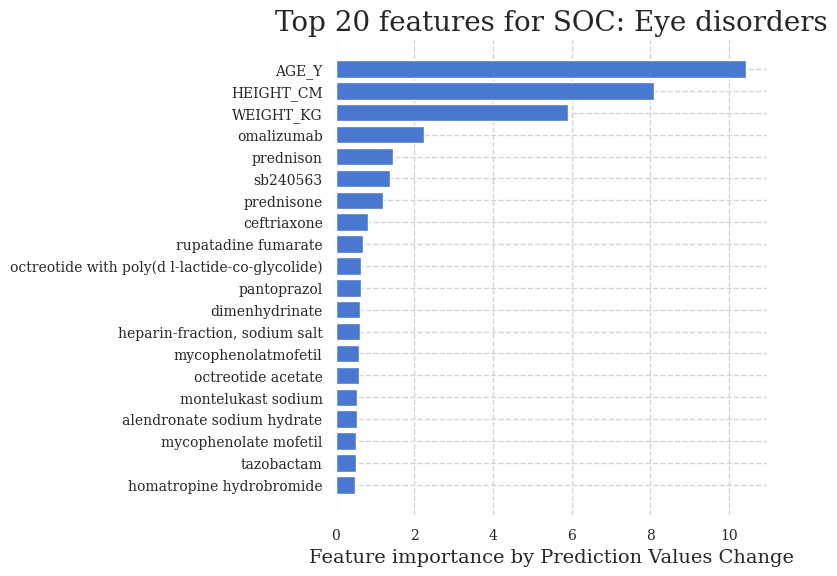

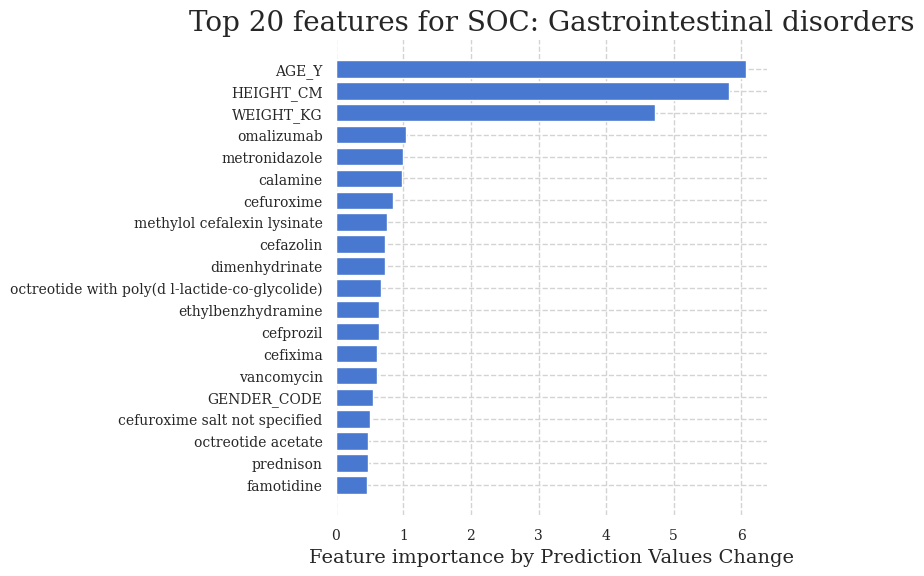

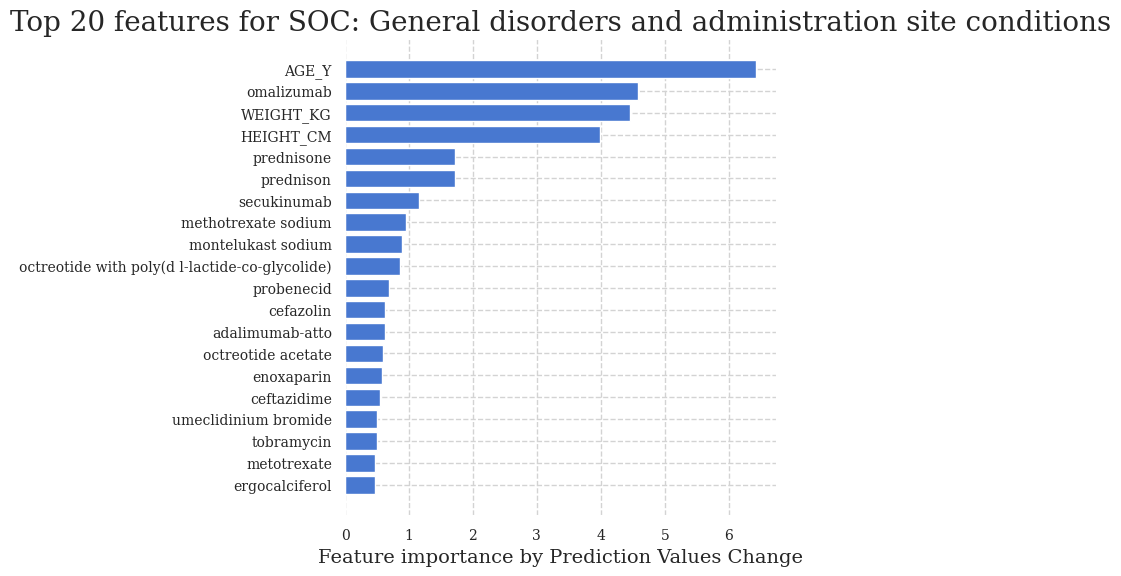

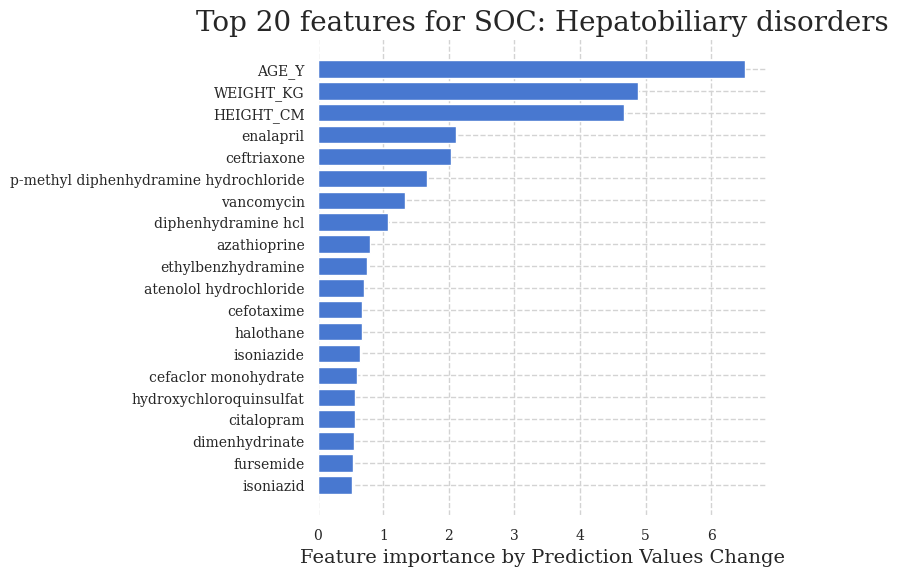

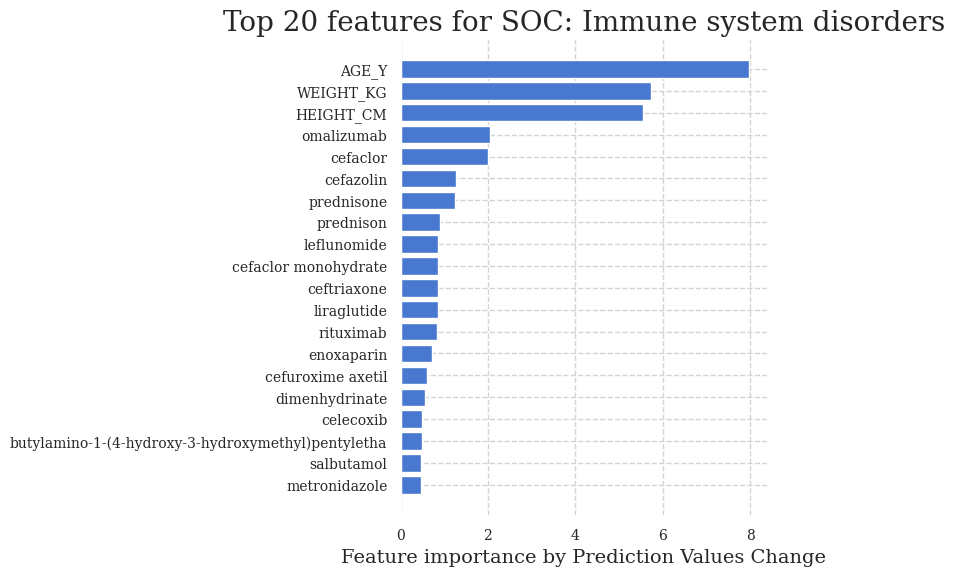

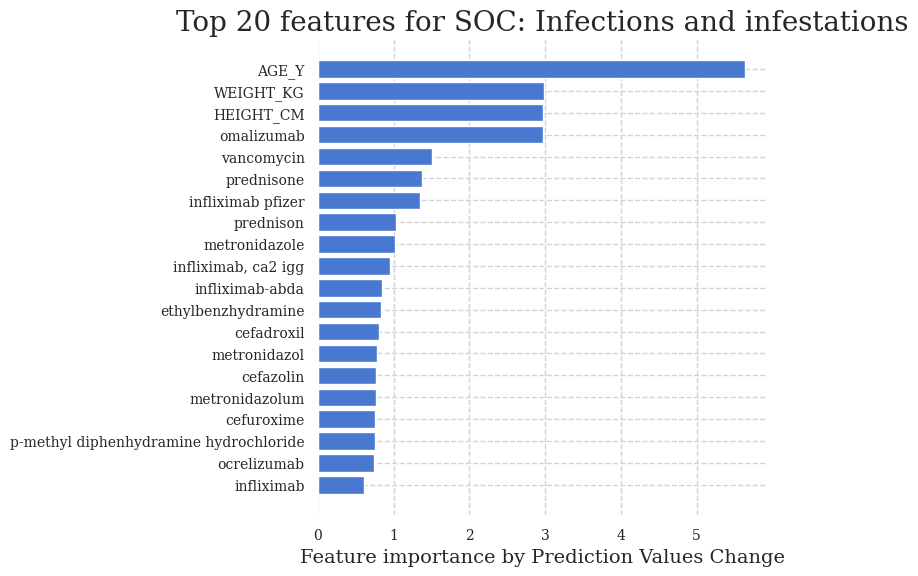

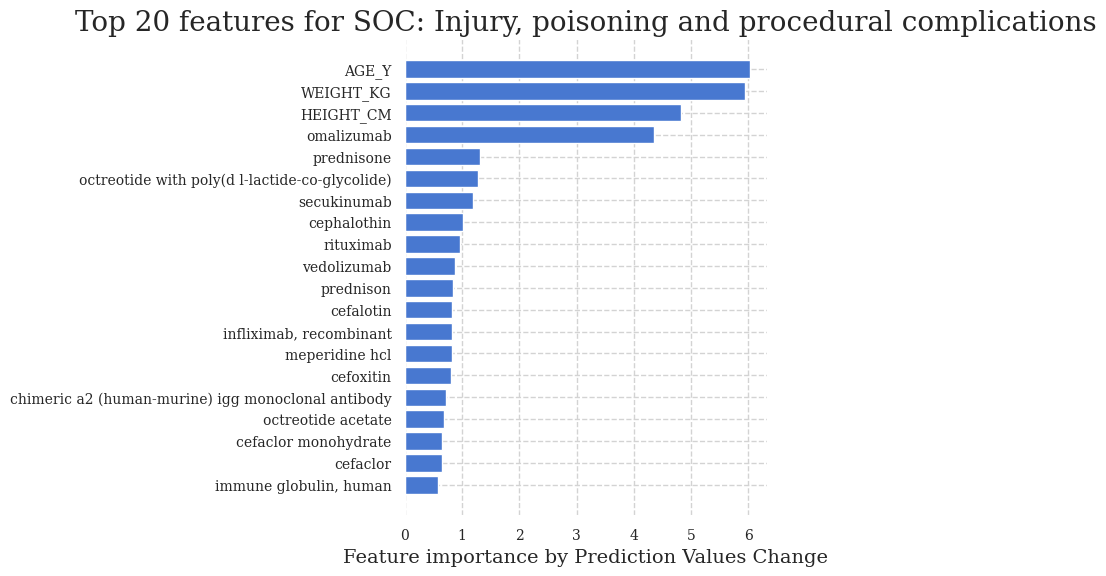

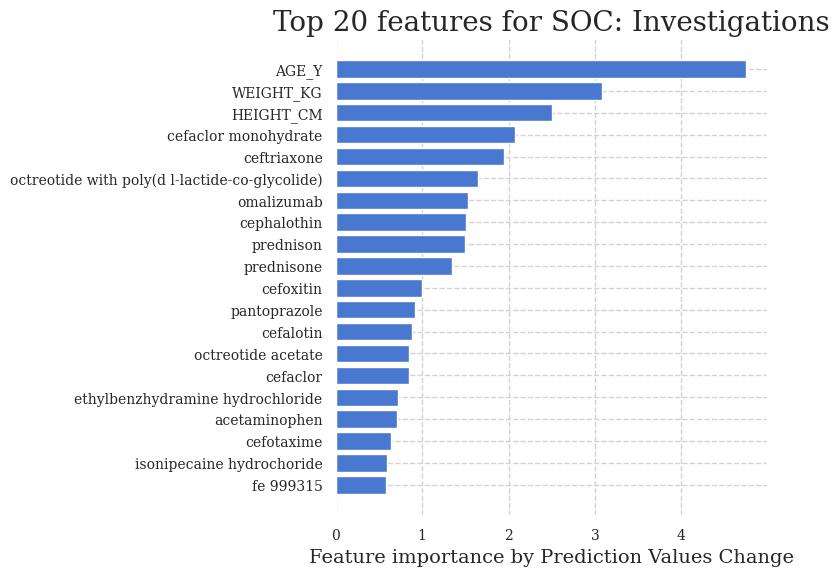

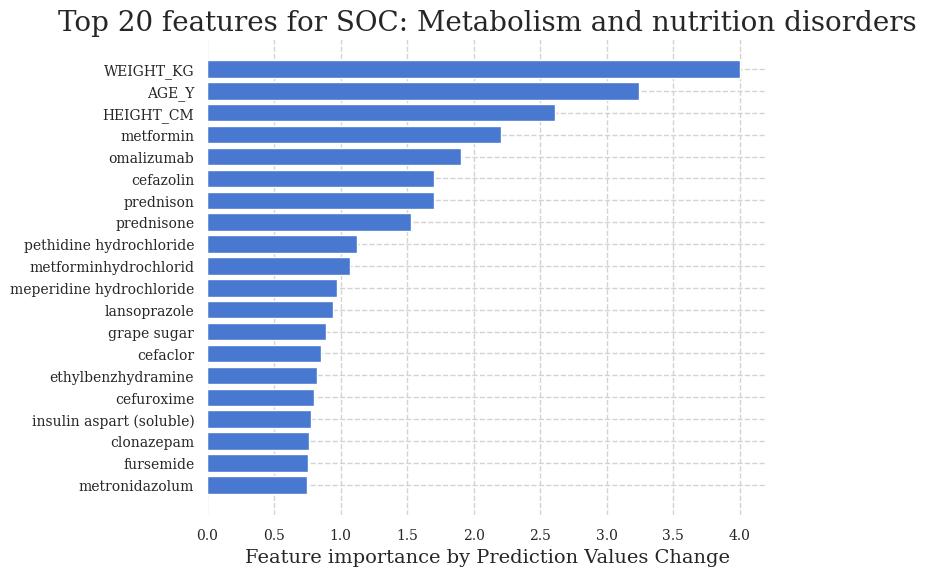

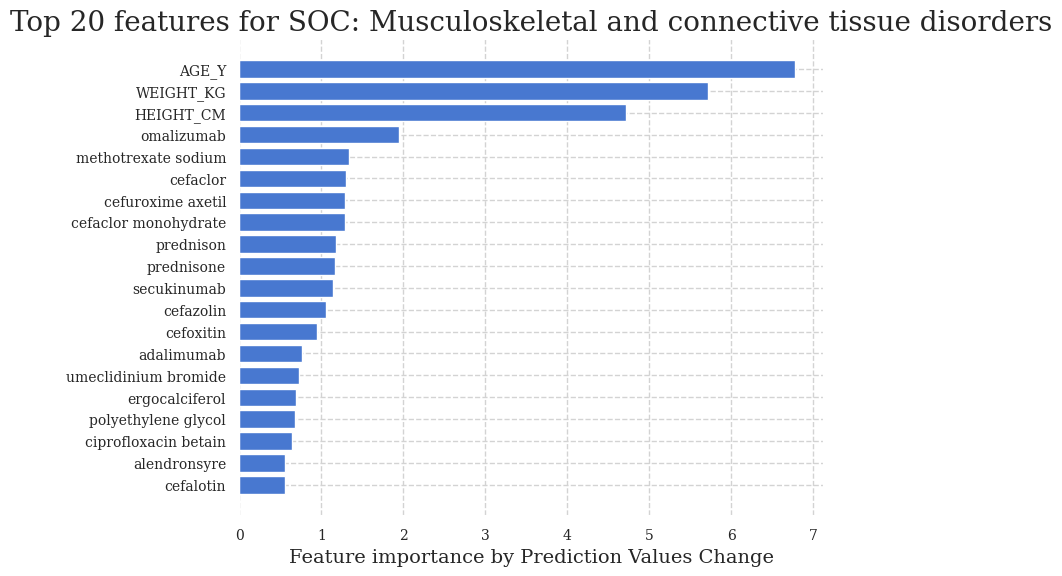

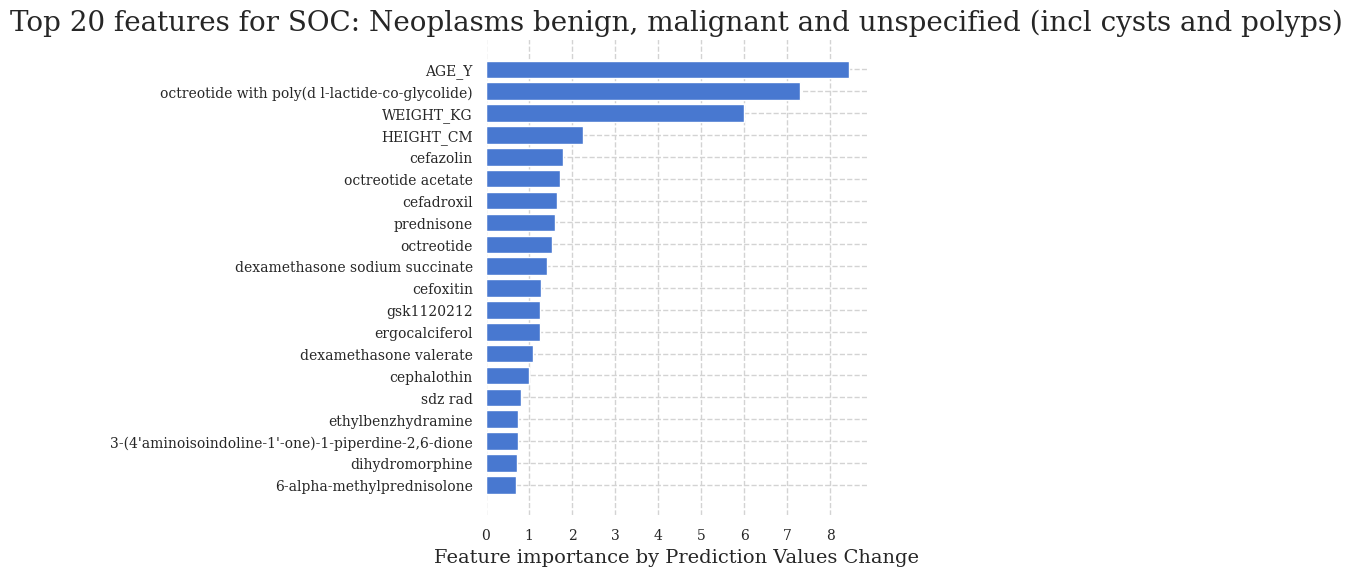

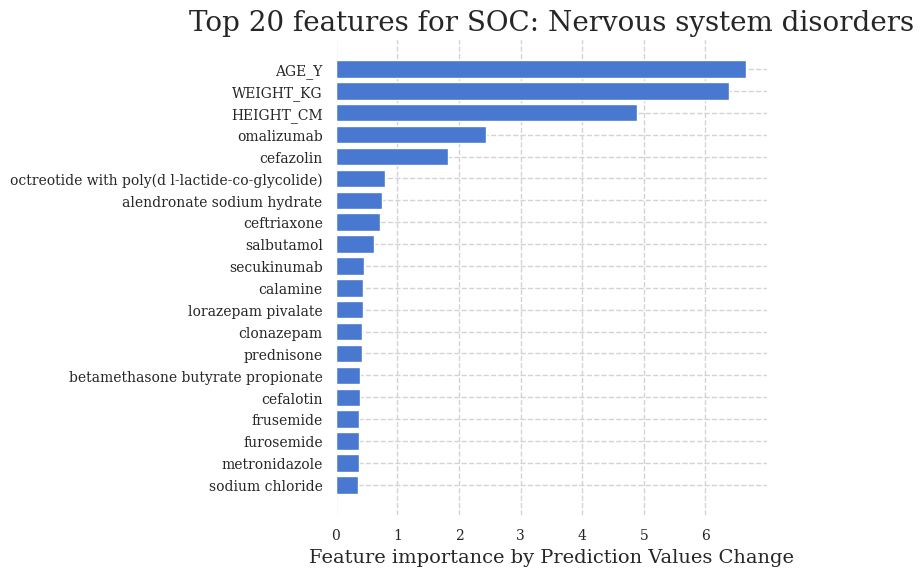

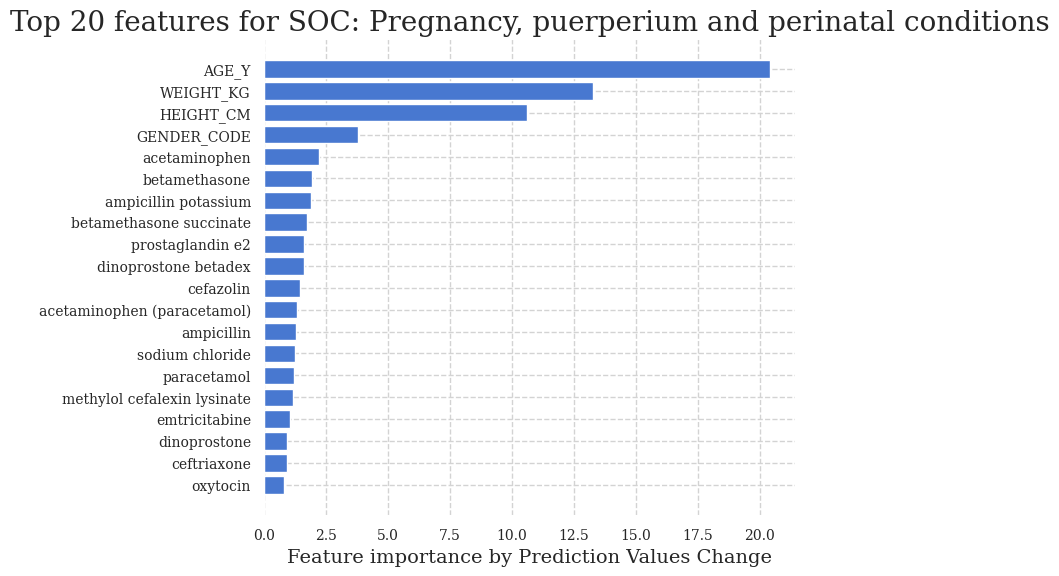

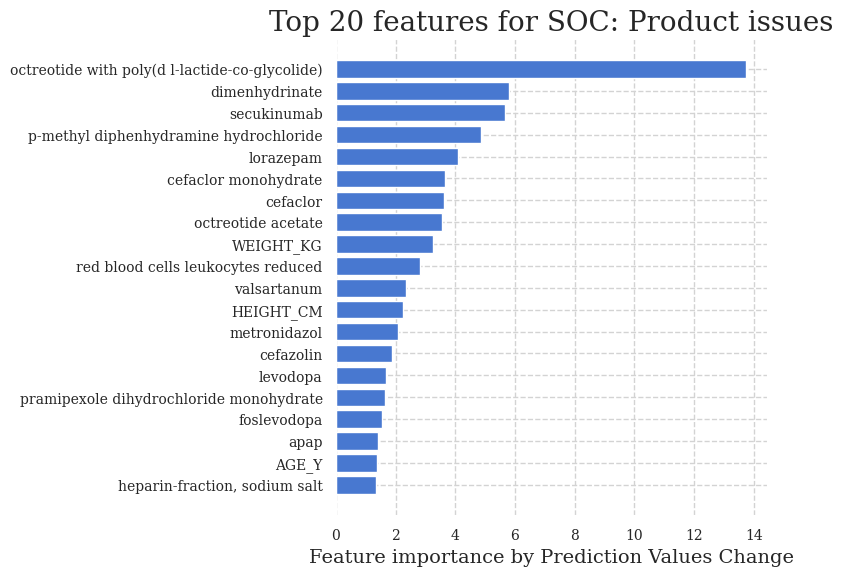

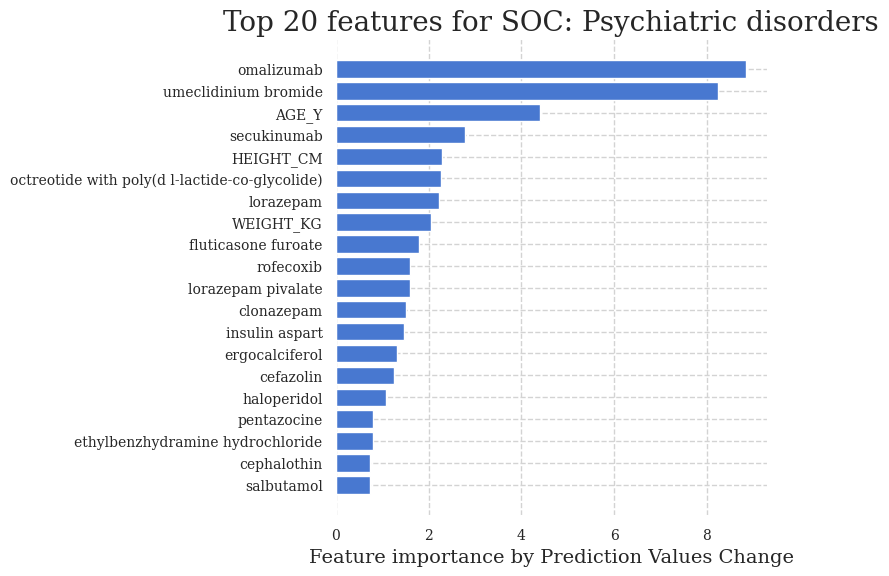

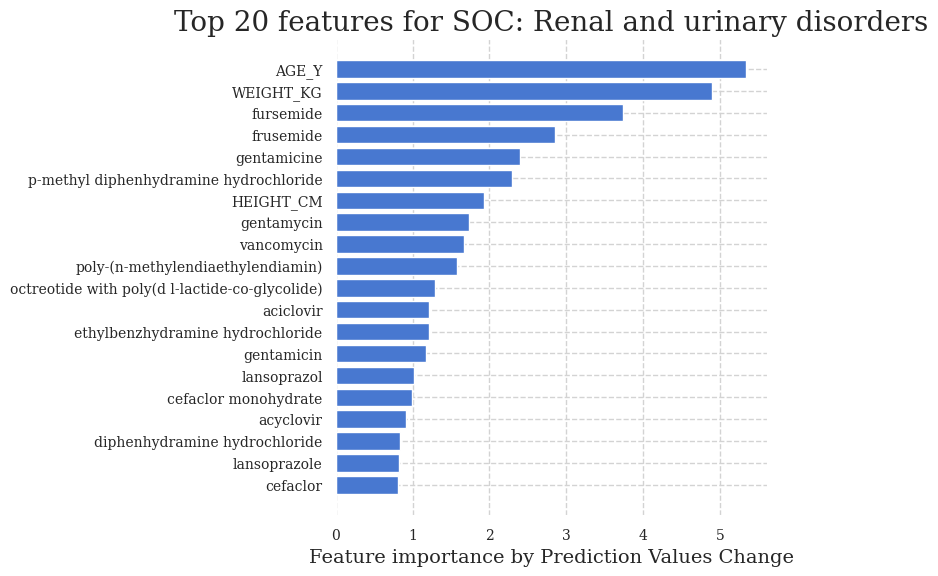

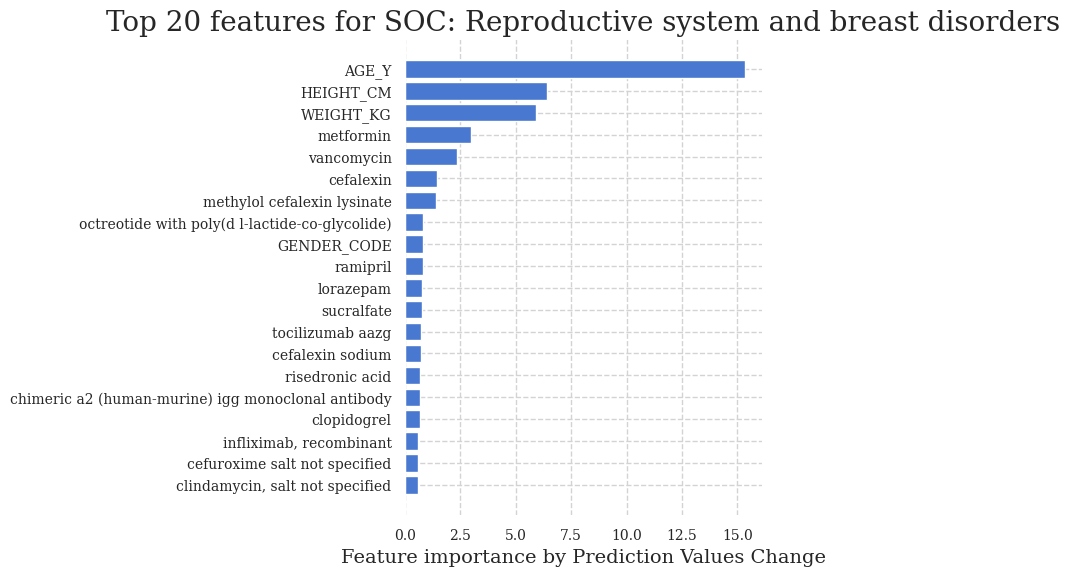

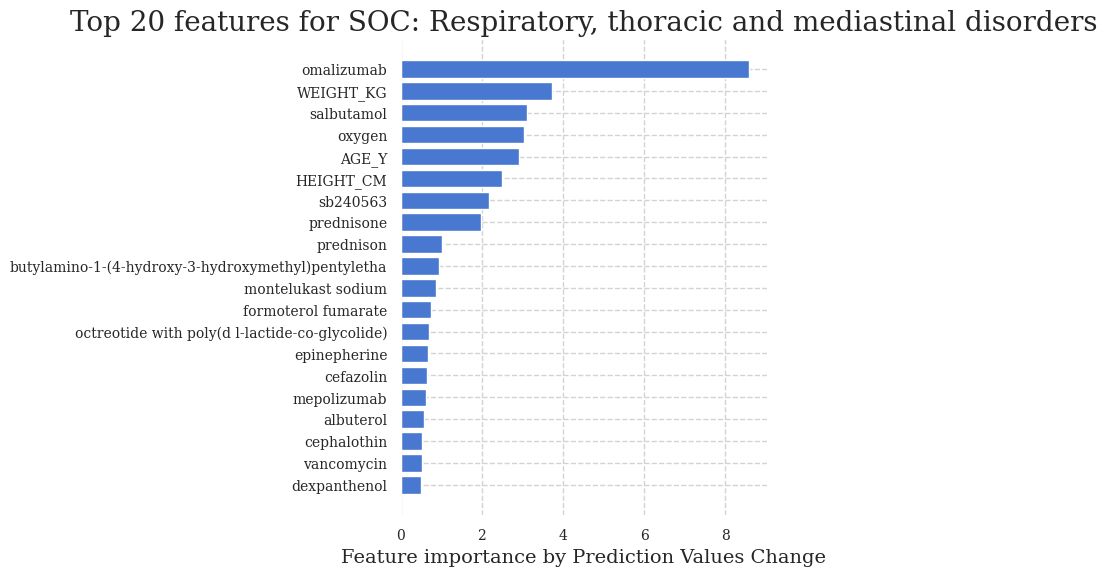

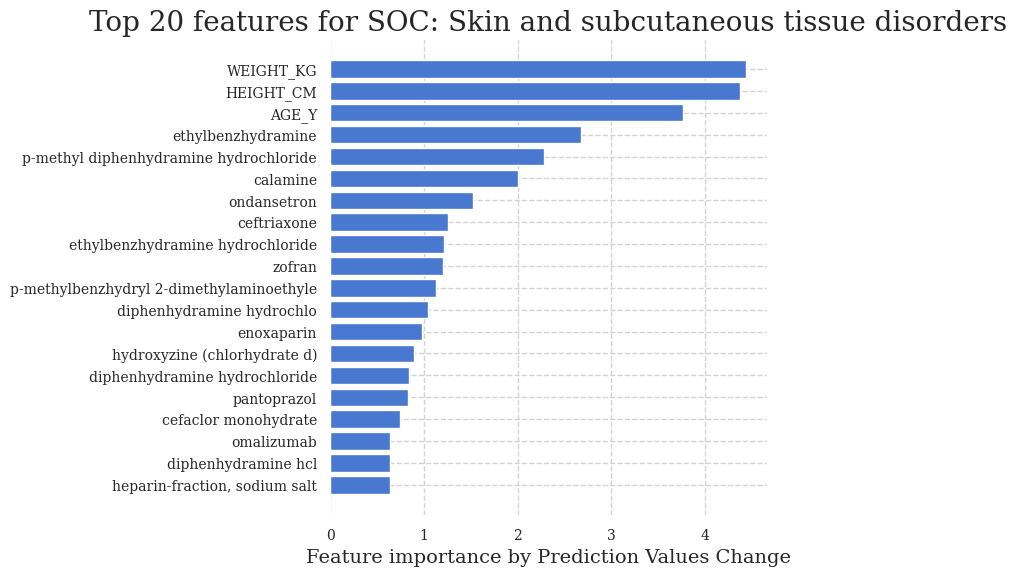

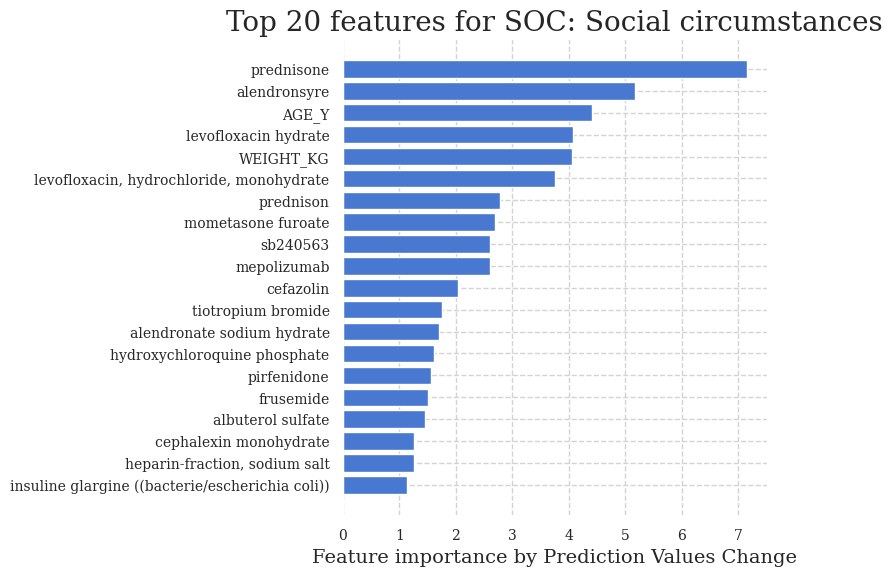

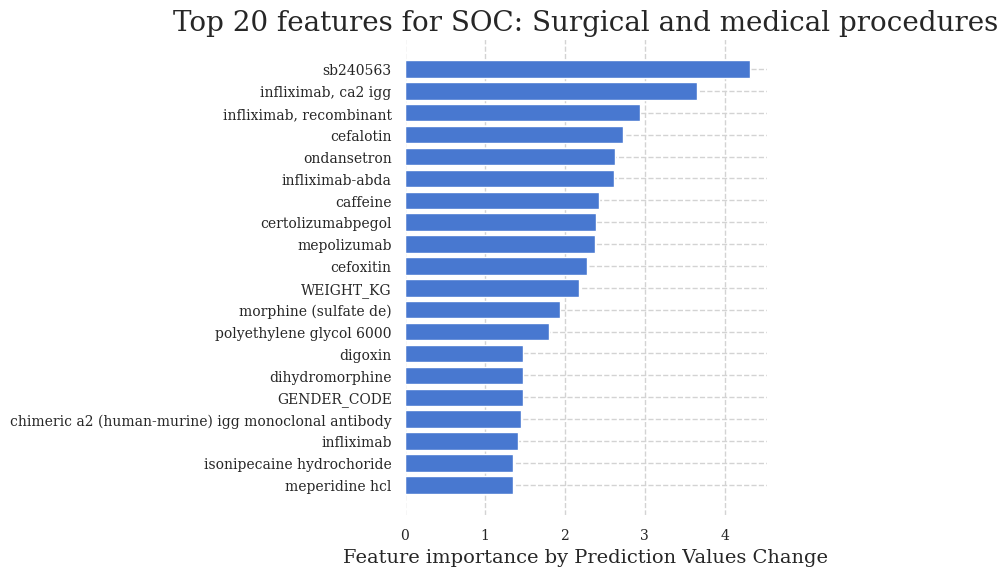

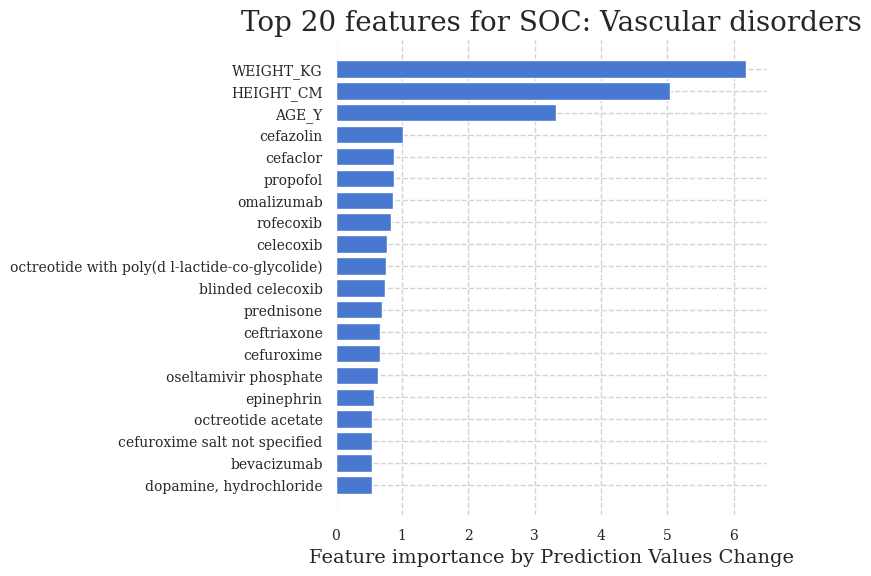

In [27]:
def plot_top_features_for_soc(
    soc_name,
    feature_importances_df,
    top_n=20,
    figsize=(8, 6),
    importance_type="FeatureImportance"
):
    """
    Plot the top_n most important features for a given SOC.
    """
    imp = feature_importances_df.loc[soc_name].sort_values(ascending=False).head(top_n)

    plt.figure(figsize=figsize)
    plt.barh(imp.index, imp.values)
    plt.title(f"Top {top_n} features for SOC: {soc_name}")
    plt.xlabel(f"Feature importance by {importance_type}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

for soc in soc_names:
    plot_top_features_for_soc(
        soc,
        feature_importances,
        importance_type="Feature Importance"
    )

for soc in soc_names:
    plot_top_features_for_soc(
        soc,
        feature_importances_pvc,
        importance_type="Prediction Values Change"
    )